In [1]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_30.npy")
#GADF = np.nan_to_num(GADF)

for i in range(15):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

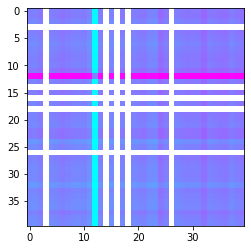

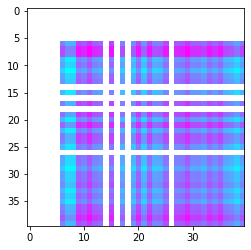

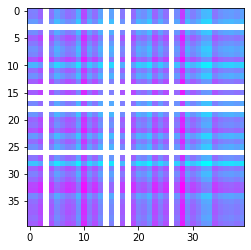

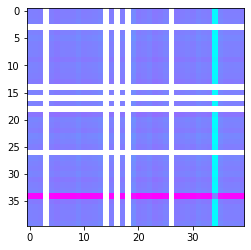

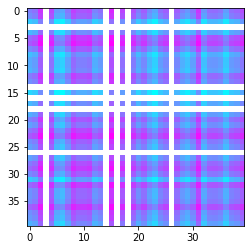

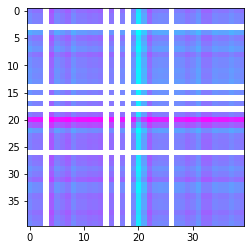

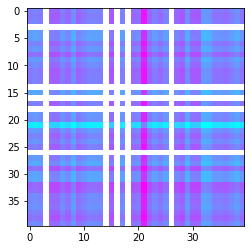

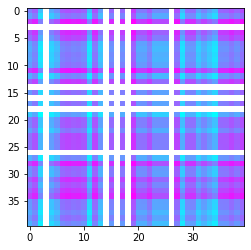

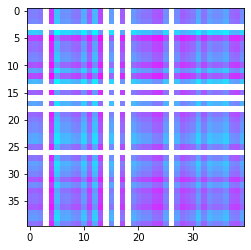

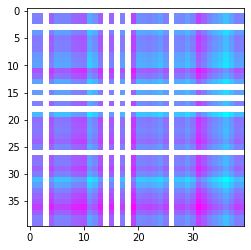

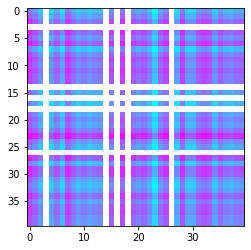

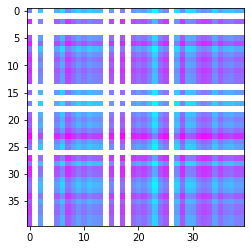

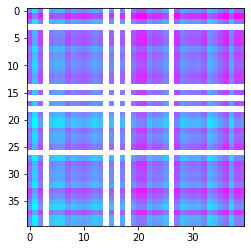

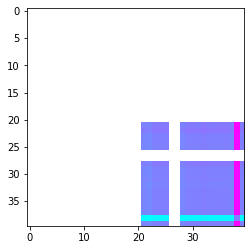

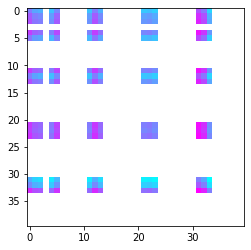

In [2]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_40.npy")

for i in range(15):
    plt.imshow(GADF[i], cmap='cool')

    plt.show()

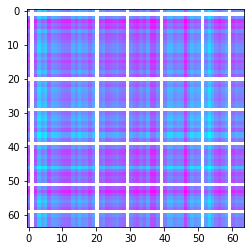

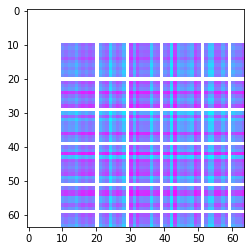

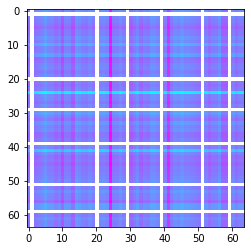

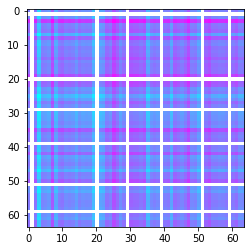

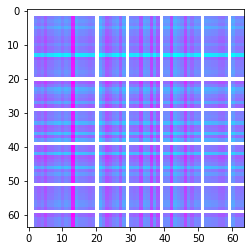

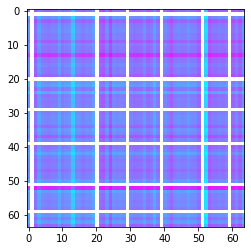

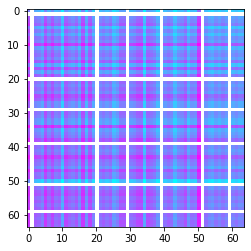

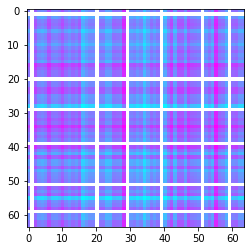

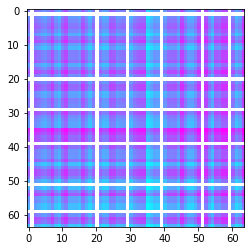

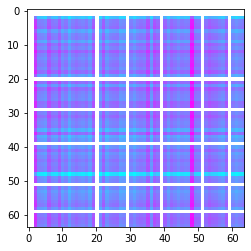

In [3]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_64.npy")

for i in range(10):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

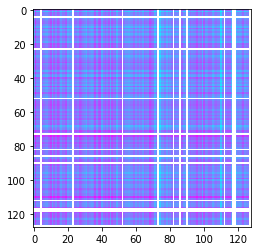

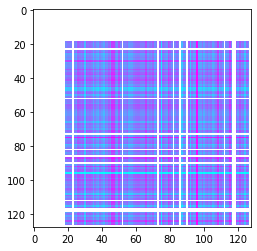

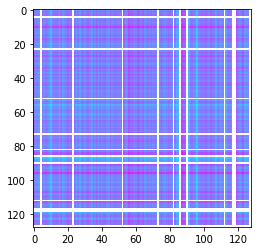

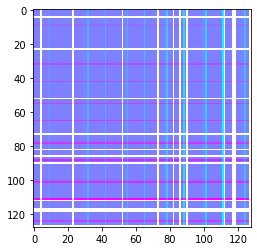

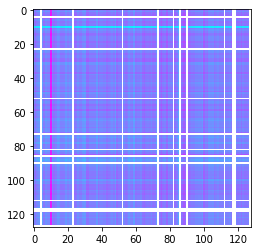

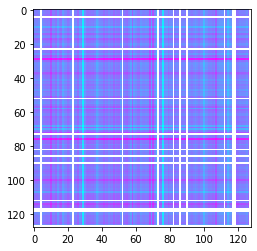

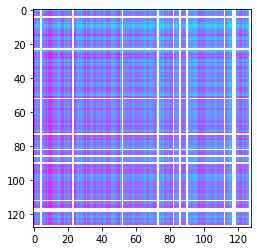

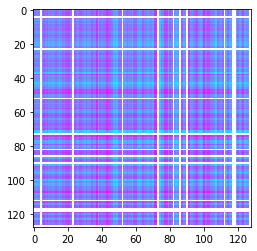

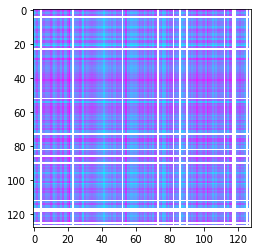

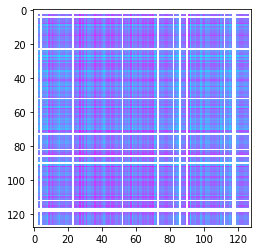

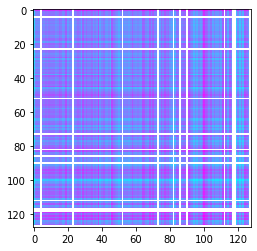

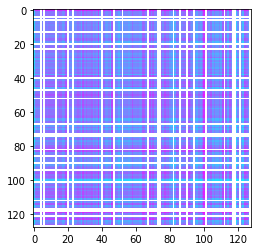

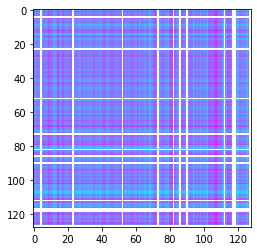

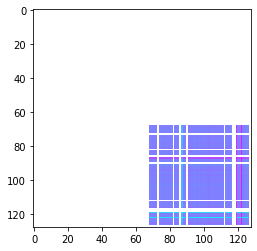

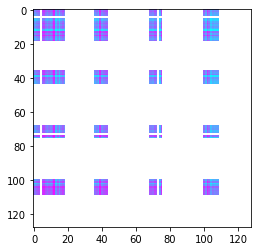

In [4]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_128.npy")

for i in range(15):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

In [17]:
np.nanmin(GADF[3])

-0.9436189

In [9]:
SIZE = 64

In [5]:
!ls /work/work_teamEXOPLANET/MTF_margarita/no_invertidos/

MTF_u10_d10.npy  MTF_u15_d20.npy  MTF_u32_d32.npy  MTF_u64_d16.npy
MTF_u10_d15.npy  MTF_u15_d30.npy  MTF_u32_d64.npy  MTF_u64_d32.npy
MTF_u10_d20.npy  MTF_u16_d16.npy  MTF_u5_d10.npy   MTF_u64_d64.npy
MTF_u10_d30.npy  MTF_u16_d32.npy  MTF_u5_d15.npy
MTF_u15_d10.npy  MTF_u16_d64.npy  MTF_u5_d20.npy
MTF_u15_d15.npy  MTF_u32_d16.npy  MTF_u5_d30.npy


In [41]:
inps = ["MTF","GADF","GASF"]
SIZE = 64
data_aug = True

In [44]:
import numpy as np
import pandas as pd
def prepare_lc_GAF(fluxs): #rango entre -1 y 1
    max_f = np.nanmax(fluxs)
    min_f = np.nanmin(fluxs)
    return (2*fluxs- max_f - min_f)/(max_f-min_f)


def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    MTF_o = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u%d_d%d.npy'%(SIZE/2,SIZE/2))  
    MTF_inv = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u%d_d%d.npy'%(SIZE/2,SIZE/2))  
    T_o = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/MTF_time_u%d_d%d.npy'%(SIZE/2,SIZE/2))  
    GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_%d.npy"%SIZE) #tambien se puede hacer inversa (trans)
    GASF = np.load("/work/work_teamEXOPLANET/GAF/GASF_%d.npy"%SIZE)
    
    #pro-process GAF : scale > fill nan
    GADF = prepare_lc_GAF(GADF)  #scale -1 y 1
    GASF = prepare_lc_GAF(GASF)  #scale -1 y 1
    #fill nan with??
    GADF = np.nan_to_num(GADF)
    GASF = np.nan_to_num(GASF)

    x_all = []
    if "MTF" in inps:
        x_all.append(MTF_o[:,:,:,None])
    if "GADF":
        x_all.append(GADF[:,:,:,None])
    if "GASF":
        x_all.append(GASF[:,:,:,None]) 
    if "Time":
        x_all.append(T_o[:,:,:,None])
    x_all = np.concatenate(x_all, axis=-1)
    print("shape:",x_all.shape)
    if data_aug:
        x_all2 = []
        if "MTF" in inps:
            x_all2.append(MTF_inv[:,:,:,None])
        if "GADF":
            x_all2.append(GADF[:,:,:,None].transpose([0,2,1,3]))
        if "GASF":
            x_all2.append(GASF[:,:,:,None].transpose([0,2,1,3])) 
        if "Time":
            x_all2.append(T_o[:,:,:,None])
        x_all2 = np.concatenate(x_all2, axis=-1)
        print("shape augment:",x_all2.shape)

    fold ="../../KOI_Data/"
    df_sets = pd.read_csv(fold+"/koi_sets.csv") 
    mask_train = (df_sets["Set"] == "Train").values
    mask_test = (df_sets["Set"] == "Test").values

    df_meta = pd.read_csv(fold+"/koi_metadata.csv")
    df_meta_train = df_meta[mask_train]
    df_meta_test = df_meta[mask_test]
    y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
    y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_val, counts_val = np.unique(y_val, return_counts=True)

    if data_aug:
        x_train1 = x_all[mask_train]
        x_train2 = x_all2[mask_train]
        x_train = np.concatenate([x_train1,x_train2]) #concat

        x_val = x_all[mask_test]

        if x_train.shape[0] != y_train.shape[0]:
            y_train = np.tile(y_train, (2))
    else:
        x_train = x_all[mask_train]
        x_val = x_all[mask_test]
    
    print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
    print ("Objetos de validación:",x_val.shape,y_val.shape)

    return x_train, y_train, x_val, y_val

In [45]:
x_train, y_train, x_val, y_val = data()

shape: (8054, 64, 64, 4)
shape augment: (8054, 64, 64, 4)
Objetos de entrenamiento: (8678, 64, 64, 4) (8678,)
Objetos de validación: (1918, 64, 64, 4) (1918,)


In [46]:
import keras, os, sys
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from sklearn.metrics import f1_score
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from utils import binary_focal_loss
from evaluation import calculate_metrics
keras.losses.binary_focal_loss_fixed = keras.losses.mse

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return 
    
def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,save_f='best_mod2.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    #if not focal:
    #    calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()

In [47]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    return model

In [48]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())
    #model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    return model

In [49]:
model = define_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 62, 62, 32)        1184      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 12, 12, 64)        18496     
__________

In [ ]:
## algun gad por si solo?

In [ ]:
plt.imshow()

### GADF + GASF (128)

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 13s 3ms/step - loss: 0.8291 - acc: 0.6056 - val_loss: 0.6583 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 13s 3ms/step - loss: 0.6249 - acc: 0.6453 - val_loss: 0.6511 - val_acc: 0.5668
 - val_f1: 0.496694 
Epoch 3/200
3905/3905 [==============================] - 12s 3ms/step - loss: 0.6014 - acc: 0.6494 - val_loss: 0.6317 - val_acc: 0.5691
 - val_f1: 0.494239 
Epoch 4/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.6005 - acc: 0.6497 - val_loss: 0.6341 - val_acc: 0.5668
 - val_f1: 0.496694 
Epoch 5/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5758 - acc: 0.6633 - val_loss: 0.6145 - val_acc: 0.5737
 - val_f1: 0.501710 
Epoch 6/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5719 - acc: 0.6586 - val_loss: 0.6069 - val_acc: 0.5714
 - val_f1: 0.509694 
Epoch 7/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5589 - acc: 0.6689 - val_loss: 0.6030 - val_acc: 0.5806
 - val_f1: 0.522015 
Epoch 8/200
3905/3905 [==============

 - val_f1: 0.589495 
Epoch 54/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.1168 - acc: 0.9657 - val_loss: 1.5922 - val_acc: 0.5945
 - val_f1: 0.574510 
Epoch 55/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.1078 - acc: 0.9608 - val_loss: 1.6731 - val_acc: 0.6014
 - val_f1: 0.576600 
Epoch 56/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0933 - acc: 0.9729 - val_loss: 1.7508 - val_acc: 0.5968
 - val_f1: 0.572707 
Epoch 57/200
3905/3905 [==============================] - 10s 3ms/step - loss: 0.1065 - acc: 0.9634 - val_loss: 1.5575 - val_acc: 0.6037
 - val_f1: 0.583298 
Epoch 58/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.1017 - acc: 0.9665 - val_loss: 1.6276 - val_acc: 0.6014
 - val_f1: 0.585482 
Epoch 59/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0952 - acc: 0.9672 - val_loss: 1.6613 - val_acc: 0.6129
 - val_f1: 0.585284 
Epoch 60/200
3905/3905 [=======

 - val_f1: 0.596306 
Epoch 106/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0510 - acc: 0.9839 - val_loss: 2.2223 - val_acc: 0.6290
 - val_f1: 0.614235 
Epoch 107/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0564 - acc: 0.9821 - val_loss: 2.4113 - val_acc: 0.6083
 - val_f1: 0.587249 
Epoch 108/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0499 - acc: 0.9859 - val_loss: 2.2526 - val_acc: 0.6106
 - val_f1: 0.595816 
Epoch 109/200
3905/3905 [==============================] - 12s 3ms/step - loss: 0.0494 - acc: 0.9859 - val_loss: 2.4645 - val_acc: 0.6037
 - val_f1: 0.575410 
Epoch 110/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0477 - acc: 0.9872 - val_loss: 2.3709 - val_acc: 0.6129
 - val_f1: 0.592989 
Epoch 111/200
3905/3905 [==============================] - 12s 3ms/step - loss: 0.0531 - acc: 0.9826 - val_loss: 2.3878 - val_acc: 0.6014
 - val_f1: 0.579502 
Epoch 112/200
3905/3905 [

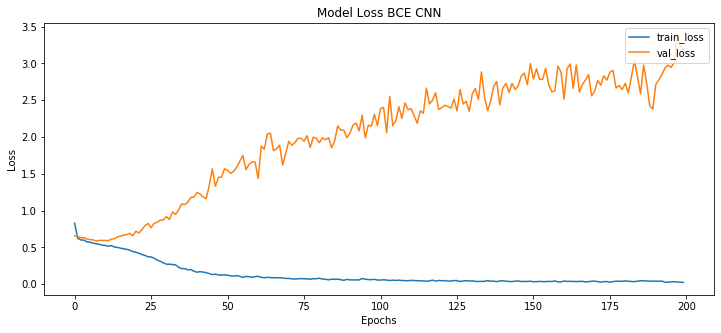

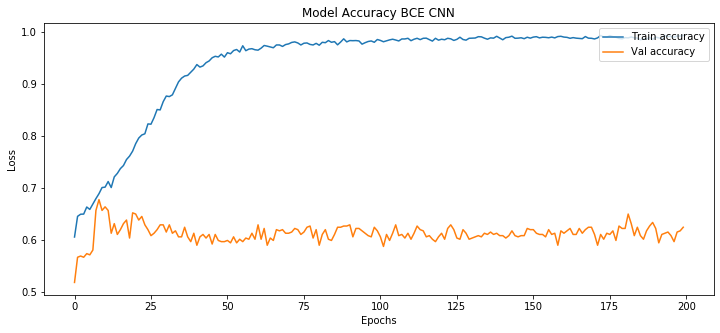

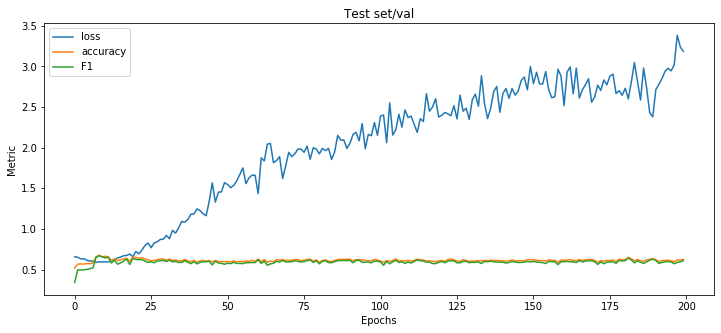

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.803410,0.642342,0.713904,0.672913,0.655319,0.665276
Confirmed,0.515744,0.707899,0.596734,0.672913,0.655319,0.665276


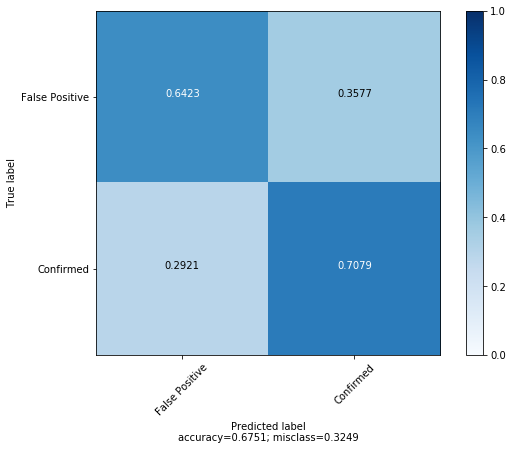

{'Precision raw': array([0.80341023, 0.51574376]),
 'Recall raw': array([0.64234162, 0.70789866]),
 'F1 raw': array([0.71390374, 0.59673367]),
 'F1 weighted': 0.672912543989429,
 'F1 macro': 0.6553187058286083,
 'F1 micro': 0.6652763295099061,
 'Confusion Matrix': array([[801, 446],
        [196, 475]])}

In [20]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 13s 3ms/step - loss: 26.0914 - acc: 0.5457 - val_loss: 9.8612 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 12s 3ms/step - loss: 9.8937 - acc: 0.6412 - val_loss: 9.7815 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 3/200
3905/3905 [==============================] - 12s 3ms/step - loss: 9.5636 - acc: 0.6415 - val_loss: 9.6873 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 4/200
3905/3905 [==============================] - 11s 3ms/step - loss: 9.4840 - acc: 0.6525 - val_loss: 9.5988 - val_acc: 0.5645
 - val_f1: 0.465235 
Epoch 5/200
3905/3905 [==============================] - 11s 3ms/step - loss: 9.3869 - acc: 0.6502 - val_loss: 9.5502 - val_acc: 0.5691
 - val_f1: 0.487726 
Epoch 6/200
3905/3905 [==============================] - 11s 3ms/step - loss: 9.1620 - acc: 0.6673 - val_loss: 9.6058 - val_acc: 0.5806
 - val_f1: 0.510789 
Epoch 7/200
3905/3905 [==============================] - 11s 3ms/step - loss: 9.0690 - acc: 0.6781 - val_loss: 9.4506 - val_acc: 0.5991
 - val_f1: 0.541327 
Epoch 8/200
3905/3905 [==============

3905/3905 [==============================] - 11s 3ms/step - loss: 0.6813 - acc: 0.9877 - val_loss: 54.6460 - val_acc: 0.5968
 - val_f1: 0.577368 
Epoch 105/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.6766 - acc: 0.9869 - val_loss: 55.9036 - val_acc: 0.5876
 - val_f1: 0.562941 
Epoch 106/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5971 - acc: 0.9882 - val_loss: 55.6172 - val_acc: 0.5899
 - val_f1: 0.570565 
Epoch 107/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5941 - acc: 0.9872 - val_loss: 55.3101 - val_acc: 0.5899
 - val_f1: 0.566866 
Epoch 108/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.6060 - acc: 0.9895 - val_loss: 55.8113 - val_acc: 0.5806
 - val_f1: 0.557133 
Epoch 109/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5626 - acc: 0.9898 - val_loss: 54.1767 - val_acc: 0.5806
 - val_f1: 0.554042 
Epoch 110/200
3905/3905 [=============================

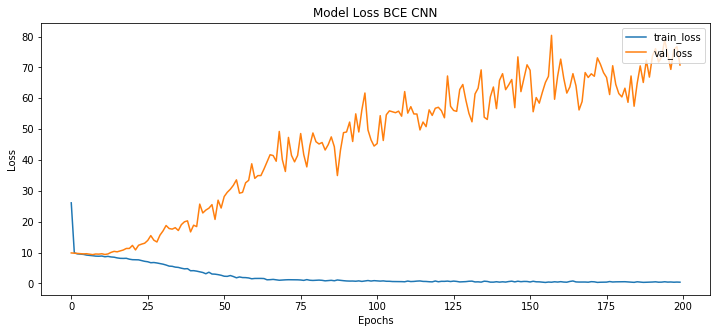

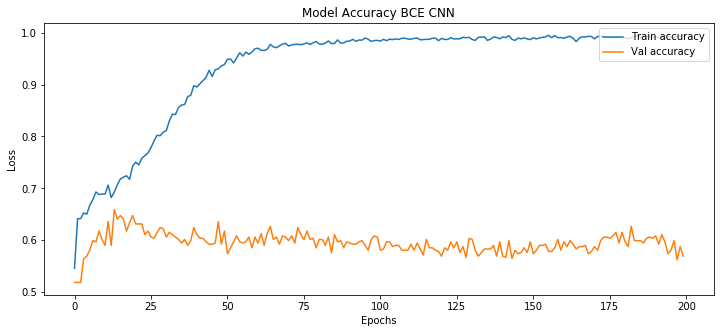

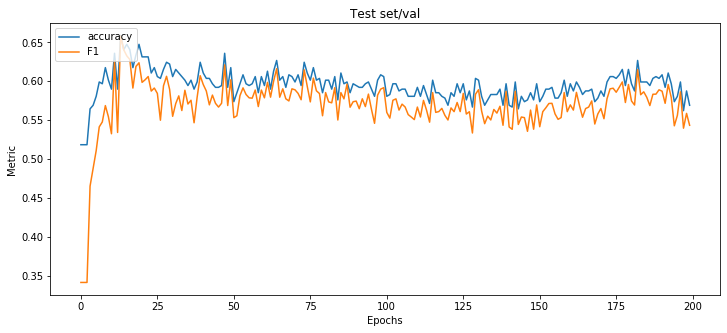

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.689655,0.962310,0.803482,0.63035,0.55604,0.693952
Confirmed,0.735955,0.195231,0.308598,0.63035,0.55604,0.693952


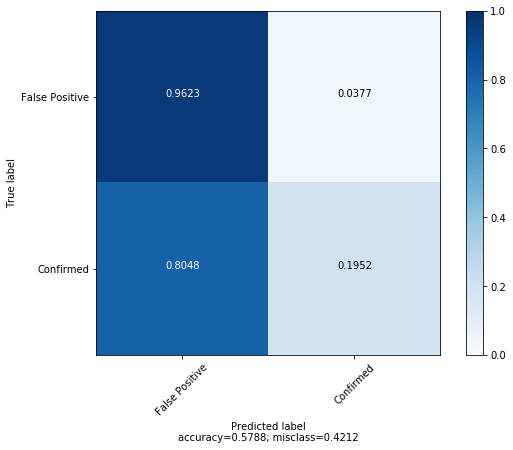

{'Precision raw': array([0.68965517, 0.73595506]),
 'Recall raw': array([0.96230954, 0.195231  ]),
 'F1 raw': array([0.80348175, 0.30859835]),
 'F1 weighted': 0.6303499692881157,
 'F1 macro': 0.5560400526348374,
 'F1 micro': 0.6939520333680917,
 'Confusion Matrix': array([[1200,   47],
        [ 540,  131]])}

In [21]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

### GADF + GASF (30)

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.6695 - acc: 0.6376 - val_loss: 0.6756 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 3s 734us/step - loss: 0.6107 - acc: 0.6384 - val_loss: 0.6189 - val_acc: 0.5507
 - val_f1: 0.521613 
Epoch 3/200
3905/3905 [==============================] - 3s 642us/step - loss: 0.5895 - acc: 0.6233 - val_loss: 0.6274 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 4/200
3905/3905 [==============================] - 2s 632us/step - loss: 0.5833 - acc: 0.6430 - val_loss: 0.6198 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 5/200
3905/3905 [==============================] - 3s 724us/step - loss: 0.5809 - acc: 0.6376 - val_loss: 0.6155 - val_acc: 0.5392
 - val_f1: 0.424098 
Epoch 6/200
3905/3905 [==============================] - 3s 713us/step - loss: 0.5782 - acc: 0.6471 - val_loss: 0.6252 - val_acc: 0.5184
 - val_f1: 0.349848 
Epoch 7/200
3905/3905 [==============================] - 3s 687us/step - loss: 0.5802 - acc: 0.6499 - val_loss: 0.6156 - val_acc: 0.5668
 - val_f1: 0.476827 
Epoch 8/200
3905/3905 [========

3905/3905 [==============================] - 2s 556us/step - loss: 0.1868 - acc: 0.9298 - val_loss: 1.0383 - val_acc: 0.6336
 - val_f1: 0.625755 
Epoch 105/200
3905/3905 [==============================] - 2s 615us/step - loss: 0.1781 - acc: 0.9380 - val_loss: 1.0609 - val_acc: 0.6313
 - val_f1: 0.623656 
Epoch 106/200
3905/3905 [==============================] - 2s 555us/step - loss: 0.1711 - acc: 0.9350 - val_loss: 1.1019 - val_acc: 0.6336
 - val_f1: 0.623566 
Epoch 107/200
3905/3905 [==============================] - 2s 617us/step - loss: 0.1830 - acc: 0.9332 - val_loss: 1.0576 - val_acc: 0.6267
 - val_f1: 0.618952 
Epoch 108/200
3905/3905 [==============================] - 2s 629us/step - loss: 0.1767 - acc: 0.9298 - val_loss: 1.1371 - val_acc: 0.6129
 - val_f1: 0.599288 
Epoch 109/200
3905/3905 [==============================] - 3s 712us/step - loss: 0.1768 - acc: 0.9334 - val_loss: 1.1009 - val_acc: 0.6336
 - val_f1: 0.622363 
Epoch 110/200
3905/3905 [=============================

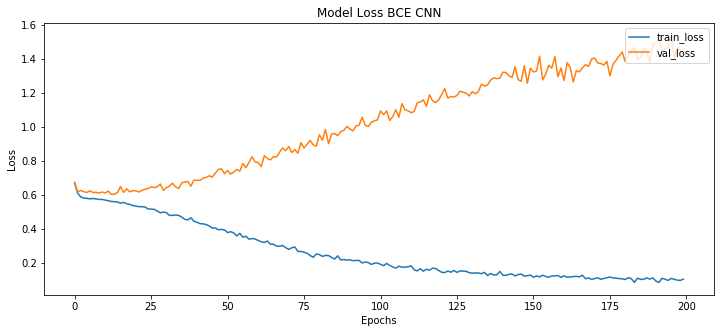

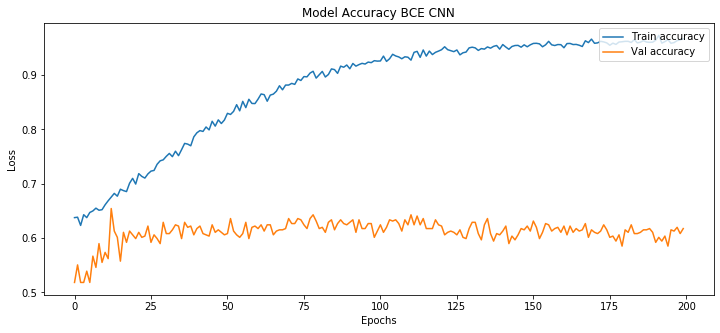

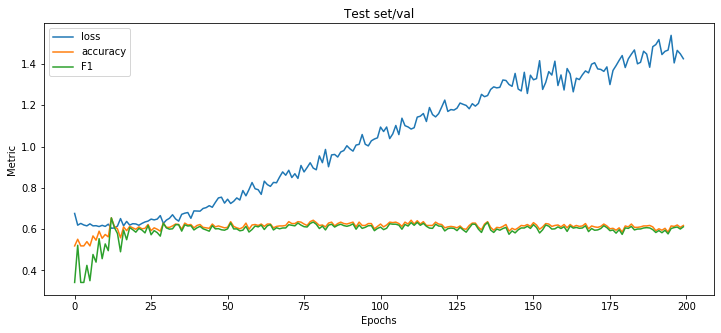

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.751779,0.677626,0.712779,0.650638,0.623967,0.644943
Confirmed,0.493703,0.584203,0.535154,0.650638,0.623967,0.644943


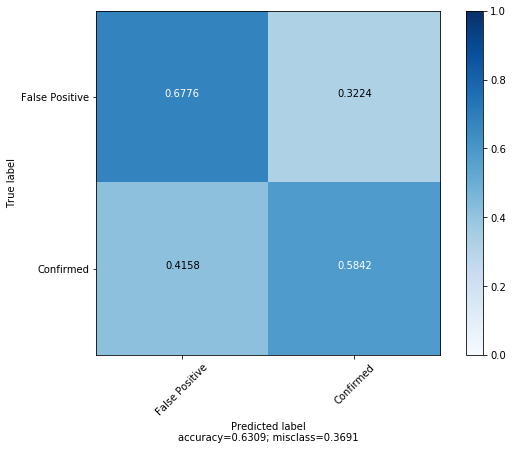

{'Precision raw': array([0.75177936, 0.49370277]),
 'Recall raw': array([0.6776263 , 0.58420268]),
 'F1 raw': array([0.71277942, 0.53515358]),
 'F1 weighted': 0.6506381589220466,
 'F1 macro': 0.623966500792425,
 'F1 micro': 0.6449426485922837,
 'Confusion Matrix': array([[845, 402],
        [279, 392]])}

In [29]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

In [12]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 4s 1ms/step - loss: 10.5100 - acc: 0.6223 - val_loss: 9.8773 - val_acc: 0.5161
 - val_f1: 0.340426 
Epoch 2/200
3905/3905 [==============================] - 3s 689us/step - loss: 9.5290 - acc: 0.6405 - val_loss: 9.4332 - val_acc: 0.5092
 - val_f1: 0.345622 
Epoch 3/200
3905/3905 [==============================] - 2s 589us/step - loss: 9.4130 - acc: 0.6397 - val_loss: 9.3910 - val_acc: 0.5346
 - val_f1: 0.427051 
Epoch 4/200
3905/3905 [==============================] - 3s 702us/step - loss: 9.3486 - acc: 0.6487 - val_loss: 9.5259 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 5/200
 256/3905 [>.............................] - ETA: 2s - loss: 9.3831 - acc: 0.6523

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3905/3905 [==============================] - 2s 625us/step - loss: 9.2690 - acc: 0.6420 - val_loss: 9.5720 - val_acc: 0.5276
 - val_f1: 0.374028 
Epoch 6/200
3905/3905 [==============================] - 2s 624us/step - loss: 9.2474 - acc: 0.6540 - val_loss: 9.6042 - val_acc: 0.5507
 - val_f1: 0.448258 
Epoch 7/200
3905/3905 [==============================] - 2s 586us/step - loss: 9.2589 - acc: 0.6625 - val_loss: 9.3515 - val_acc: 0.5576
 - val_f1: 0.515456 
Epoch 8/200
3905/3905 [==============================] - 2s 580us/step - loss: 9.2303 - acc: 0.6551 - val_loss: 9.4543 - val_acc: 0.5507
 - val_f1: 0.476905 
Epoch 9/200
3905/3905 [==============================] - 3s 692us/step - loss: 9.1601 - acc: 0.6620 - val_loss: 9.4003 - val_acc: 0.5714
 - val_f1: 0.534657 
Epoch 10/200
3905/3905 [==============================] - 2s 633us/step - loss: 9.0985 - acc: 0.6684 - val_loss: 9.6706 - val_acc: 0.5438
 - val_f1: 0.453984 
Epoch 11/200
3905/3905 [==============================] - 3s 68

KeyboardInterrupt: 

### GADF + GASF + MTF(30)

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.6543 - acc: 0.6353 - val_loss: 0.6418 - val_acc: 0.5599
 - val_f1: 0.531426 
Epoch 2/200
3905/3905 [==============================] - 2s 534us/step - loss: 0.5891 - acc: 0.6415 - val_loss: 0.6072 - val_acc: 0.6014
 - val_f1: 0.594876 
Epoch 3/200
3905/3905 [==============================] - 2s 584us/step - loss: 0.5669 - acc: 0.6451 - val_loss: 0.5910 - val_acc: 0.6498
 - val_f1: 0.649651 
Epoch 4/200
3905/3905 [==============================] - 2s 617us/step - loss: 0.5590 - acc: 0.6566 - val_loss: 0.5834 - val_acc: 0.6705
 - val_f1: 0.668350 
Epoch 5/200
3905/3905 [==============================] - 2s 562us/step - loss: 0.5535 - acc: 0.6538 - val_loss: 0.5922 - val_acc: 0.6452
 - val_f1: 0.640767 
Epoch 6/200
3905/3905 [==============================] - 2s 518us/step - loss: 0.5446 - acc: 0.6602 - val_loss: 0.5829 - val_acc: 0.6290
 - val_f1: 0.625001 
Epoch 7

3905/3905 [==============================] - 2s 438us/step - loss: 0.1981 - acc: 0.9165 - val_loss: 0.9574 - val_acc: 0.6267
 - val_f1: 0.617334 
Epoch 104/200
3905/3905 [==============================] - 2s 615us/step - loss: 0.1935 - acc: 0.9206 - val_loss: 1.0047 - val_acc: 0.6221
 - val_f1: 0.614757 
Epoch 105/200
3905/3905 [==============================] - 2s 509us/step - loss: 0.1984 - acc: 0.9216 - val_loss: 0.9595 - val_acc: 0.6014
 - val_f1: 0.589776 
Epoch 106/200
3905/3905 [==============================] - 2s 555us/step - loss: 0.1843 - acc: 0.9255 - val_loss: 1.0455 - val_acc: 0.6244
 - val_f1: 0.618738 
Epoch 107/200
3905/3905 [==============================] - 2s 589us/step - loss: 0.1912 - acc: 0.9209 - val_loss: 0.9870 - val_acc: 0.6336
 - val_f1: 0.628094 
Epoch 108/200
3905/3905 [==============================] - 2s 583us/step - loss: 0.1942 - acc: 0.9191 - val_loss: 0.9857 - val_acc: 0.6244
 - val_f1: 0.614096 
Epoch 109/200
3905/3905 [=============================

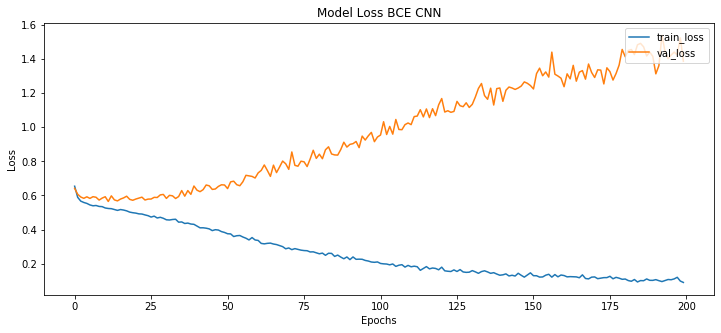

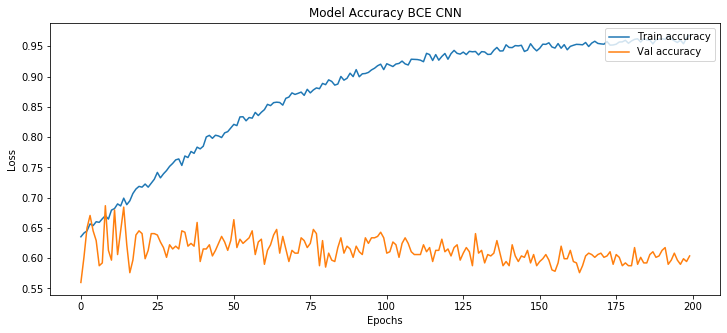

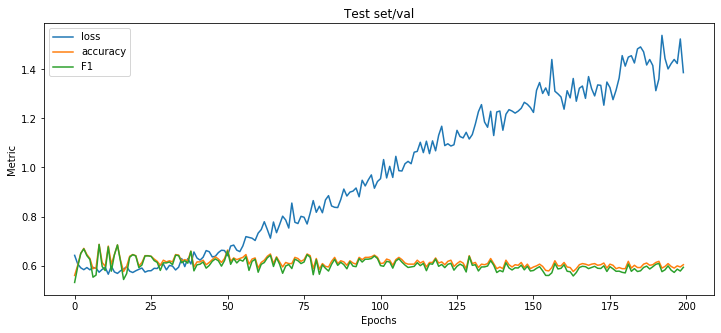

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.846585,0.606255,0.706542,0.679665,0.66813,0.672576
Confirmed,0.520976,0.795827,0.629717,0.679665,0.66813,0.672576


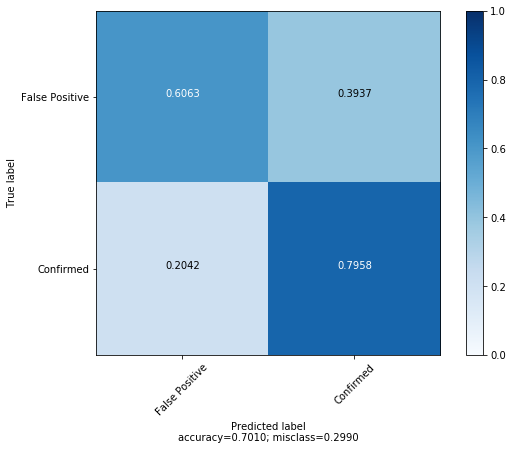

{'Precision raw': array([0.84658455, 0.52097561]),
 'Recall raw': array([0.60625501, 0.79582712]),
 'F1 raw': array([0.70654206, 0.62971698]),
 'F1 weighted': 0.6796652962799044,
 'F1 macro': 0.6681295186034211,
 'F1 micro': 0.6725755995828988,
 'Confusion Matrix': array([[756, 491],
        [137, 534]])}

In [37]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 4s 1ms/step - loss: 10.3520 - acc: 0.6254 - val_loss: 9.4424 - val_acc: 0.5853
 - val_f1: 0.562000 
Epoch 2/200
3905/3905 [==============================] - 2s 460us/step - loss: 9.5021 - acc: 0.6330 - val_loss: 9.2061 - val_acc: 0.5853
 - val_f1: 0.525510 
Epoch 3/200
3905/3905 [==============================] - 2s 577us/step - loss: 9.0509 - acc: 0.6510 - val_loss: 9.0948 - val_acc: 0.5968
 - val_f1: 0.547666 
Epoch 4/200
3905/3905 [==============================] - 3s 763us/step - loss: 8.9420 - acc: 0.6479 - val_loss: 8.8789 - val_acc: 0.6452
 - val_f1: 0.635684 
Epoch 5/200
3905/3905 [==============================] - 2s 614us/step - loss: 8.8288 - acc: 0.6558 - val_loss: 8.8146 - val_acc: 0.6221
 - val_f1: 0.608829 
Epoch 6/200
3905/3905 [==============================] - 3s 677us/step - loss: 8.8568 - acc: 0.6474 - val_loss: 8.8444 - val_acc: 0.6198
 - val_f1: 0.601518 
Epoch 

3905/3905 [==============================] - 2s 479us/step - loss: 3.1697 - acc: 0.9186 - val_loss: 16.5759 - val_acc: 0.6521
 - val_f1: 0.644090 
Epoch 104/200
3905/3905 [==============================] - 2s 542us/step - loss: 3.0844 - acc: 0.9227 - val_loss: 17.7080 - val_acc: 0.6267
 - val_f1: 0.617891 
Epoch 105/200
3905/3905 [==============================] - 2s 634us/step - loss: 3.1734 - acc: 0.9247 - val_loss: 16.4594 - val_acc: 0.6336
 - val_f1: 0.625755 
Epoch 106/200
3905/3905 [==============================] - 3s 657us/step - loss: 3.1408 - acc: 0.9255 - val_loss: 16.5704 - val_acc: 0.6267
 - val_f1: 0.618430 
Epoch 107/200
3905/3905 [==============================] - 2s 594us/step - loss: 3.2067 - acc: 0.9198 - val_loss: 16.9158 - val_acc: 0.6221
 - val_f1: 0.610805 
Epoch 108/200
3905/3905 [==============================] - 2s 553us/step - loss: 3.4212 - acc: 0.9222 - val_loss: 16.5871 - val_acc: 0.6244
 - val_f1: 0.616340 
Epoch 109/200
3905/3905 [=======================

3905/3905 [==============================] - 2s 571us/step - loss: 2.1793 - acc: 0.9488 - val_loss: 22.3825 - val_acc: 0.6221
 - val_f1: 0.609507 
Epoch 155/200
3905/3905 [==============================] - 2s 573us/step - loss: 2.1977 - acc: 0.9475 - val_loss: 23.5234 - val_acc: 0.6406
 - val_f1: 0.630380 
Epoch 156/200
3905/3905 [==============================] - 3s 669us/step - loss: 2.2849 - acc: 0.9449 - val_loss: 24.8058 - val_acc: 0.6429
 - val_f1: 0.629299 
Epoch 157/200
3905/3905 [==============================] - 2s 636us/step - loss: 2.2924 - acc: 0.9385 - val_loss: 24.2393 - val_acc: 0.6060
 - val_f1: 0.590274 
Epoch 158/200
3905/3905 [==============================] - 3s 666us/step - loss: 2.2958 - acc: 0.9506 - val_loss: 24.6156 - val_acc: 0.6175
 - val_f1: 0.608457 
Epoch 159/200
3905/3905 [==============================] - 3s 662us/step - loss: 2.2087 - acc: 0.9488 - val_loss: 25.1444 - val_acc: 0.6336
 - val_f1: 0.621086 
Epoch 160/200
3905/3905 [=======================

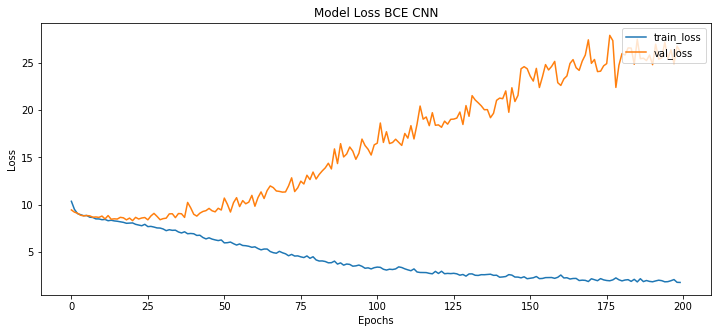

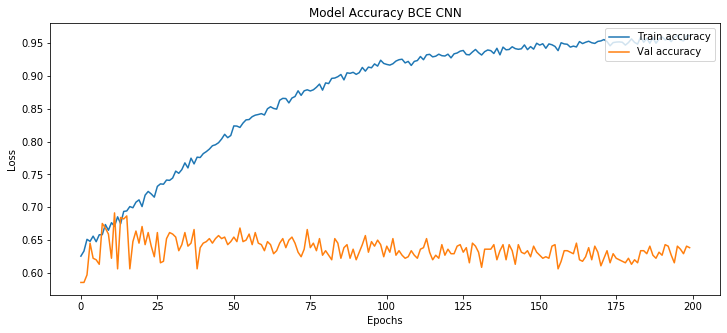

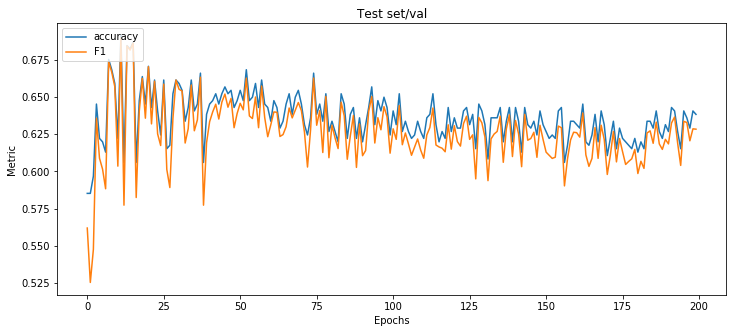

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.823411,0.654370,0.729223,0.691283,0.674999,0.684046
Confirmed,0.535059,0.739195,0.620776,0.691283,0.674999,0.684046


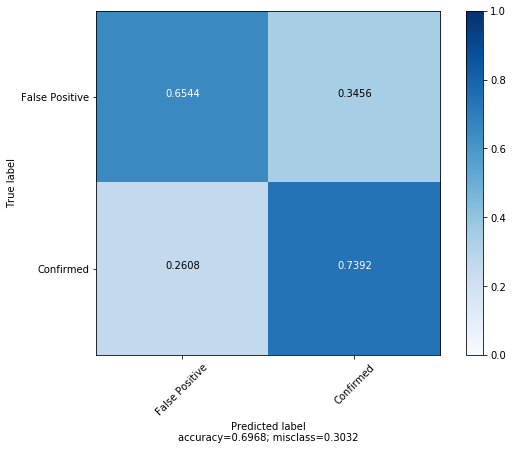

{'Precision raw': array([0.8234107 , 0.53505933]),
 'Recall raw': array([0.65437049, 0.73919523]),
 'F1 raw': array([0.72922252, 0.62077597]),
 'F1 weighted': 0.6912831899992349,
 'F1 macro': 0.6749992450348459,
 'F1 micro': 0.6840458811261731,
 'Confusion Matrix': array([[816, 431],
        [175, 496]])}

In [38]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

### tamaño 64

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3840/3905 [============================>.] - ETA: 0s - loss: 0.6552 - acc: 0.6339

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
3905/3905 [==============================] - 13s 3ms/step - loss: 0.6546 - acc: 0.6346 - val_loss: 0.6623 - val_acc: 0.5184
Epoch 2/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.6171 - acc: 0.6397 - val_loss: 0.6487 - val_acc: 0.5184
Epoch 3/200
3905/3905 [==============================] - 9s 2ms/step - loss: 0.5994 - acc: 0.6440 - val_loss: 0.6203 - val_acc: 0.5415
Epoch 4/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.5913 - acc: 0.6520 - val_loss: 0.6261 - val_acc: 0.5184
Epoch 5/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.5791 - acc: 0.6586 - val_loss: 0.6146 - val_acc: 0.6659
Epoch 6/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.5753 - acc: 0.6617 - val_loss: 0.6129 - val_acc: 0.6659
Epoch 7/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.5897 - acc: 0.6481 - val_loss: 0.6302 - val_acc: 0.5945
Epoch 8/200
3905/3905 [======================

Epoch 36/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.4808 - acc: 0.7370 - val_loss: 0.5897 - val_acc: 0.6567
Epoch 37/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.4820 - acc: 0.7431 - val_loss: 0.5909 - val_acc: 0.6359
Epoch 38/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.4756 - acc: 0.7498 - val_loss: 0.5850 - val_acc: 0.6544
Epoch 39/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.4607 - acc: 0.7654 - val_loss: 0.6223 - val_acc: 0.6567
Epoch 40/200
3905/3905 [==============================] - 9s 2ms/step - loss: 0.4556 - acc: 0.7690 - val_loss: 0.6008 - val_acc: 0.6382
Epoch 41/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.4597 - acc: 0.7662 - val_loss: 0.6101 - val_acc: 0.6590
Epoch 42/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.4522 - acc: 0.7675 - val_loss: 0.6073 - val_acc: 0.6567
Epoch 43/200
3905/3905 [========================

Epoch 71/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.3169 - acc: 0.8586 - val_loss: 0.7735 - val_acc: 0.6498
Epoch 72/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.3042 - acc: 0.8661 - val_loss: 0.8162 - val_acc: 0.6498
Epoch 73/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.2985 - acc: 0.8645 - val_loss: 0.7492 - val_acc: 0.6613
Epoch 74/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.2848 - acc: 0.8755 - val_loss: 0.8350 - val_acc: 0.6498
Epoch 75/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.2840 - acc: 0.8778 - val_loss: 0.8458 - val_acc: 0.6567
Epoch 76/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.2822 - acc: 0.8776 - val_loss: 0.8584 - val_acc: 0.6521
Epoch 77/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.2913 - acc: 0.8717 - val_loss: 0.8166 - val_acc: 0.6498
Epoch 78/200
3905/3905 [========================

Epoch 106/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.1914 - acc: 0.9257 - val_loss: 1.0825 - val_acc: 0.6521
Epoch 107/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.1796 - acc: 0.9262 - val_loss: 1.0116 - val_acc: 0.6567
Epoch 108/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1639 - acc: 0.9337 - val_loss: 1.0534 - val_acc: 0.6475
Epoch 109/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1695 - acc: 0.9293 - val_loss: 1.0733 - val_acc: 0.6567
Epoch 110/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1555 - acc: 0.9337 - val_loss: 1.1682 - val_acc: 0.6475
Epoch 111/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1762 - acc: 0.9293 - val_loss: 1.0875 - val_acc: 0.6498
Epoch 112/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.1795 - acc: 0.9250 - val_loss: 1.0780 - val_acc: 0.6590
Epoch 113/200
3905/3905 [================

3905/3905 [==============================] - 8s 2ms/step - loss: 0.1357 - acc: 0.9472 - val_loss: 1.1393 - val_acc: 0.6544
Epoch 141/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1192 - acc: 0.9526 - val_loss: 1.1706 - val_acc: 0.6475
Epoch 142/200
3905/3905 [==============================] - 9s 2ms/step - loss: 0.1172 - acc: 0.9534 - val_loss: 1.1409 - val_acc: 0.6659
Epoch 143/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1128 - acc: 0.9572 - val_loss: 1.2343 - val_acc: 0.6498
Epoch 144/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1029 - acc: 0.9608 - val_loss: 1.3509 - val_acc: 0.6613
Epoch 145/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1219 - acc: 0.9508 - val_loss: 1.2872 - val_acc: 0.6382
Epoch 146/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1151 - acc: 0.9565 - val_loss: 1.2248 - val_acc: 0.6406
Epoch 147/200
3905/3905 [==============================

3905/3905 [==============================] - 8s 2ms/step - loss: 0.0904 - acc: 0.9649 - val_loss: 1.3148 - val_acc: 0.6659
Epoch 175/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.0922 - acc: 0.9657 - val_loss: 1.3230 - val_acc: 0.6475
Epoch 176/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.0847 - acc: 0.9680 - val_loss: 1.3639 - val_acc: 0.6567
Epoch 177/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.0952 - acc: 0.9654 - val_loss: 1.3409 - val_acc: 0.6382
Epoch 178/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.0724 - acc: 0.9736 - val_loss: 1.4648 - val_acc: 0.6590
Epoch 179/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.0887 - acc: 0.9672 - val_loss: 1.4355 - val_acc: 0.6475
Epoch 180/200
3905/3905 [==============================] - 6s 2ms/step - loss: 0.0865 - acc: 0.9672 - val_loss: 1.4450 - val_acc: 0.6521
Epoch 181/200
3905/3905 [==============================

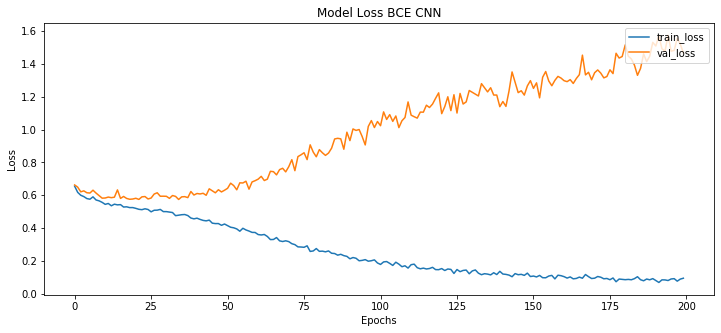

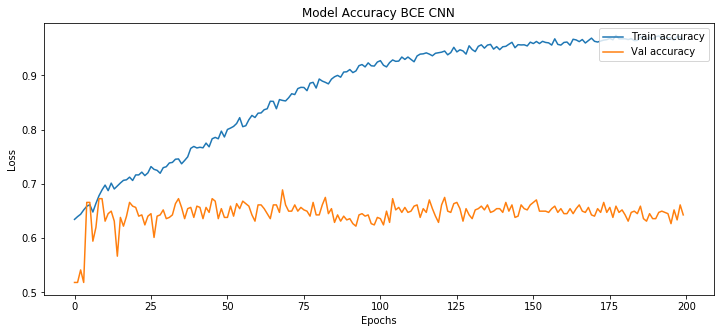

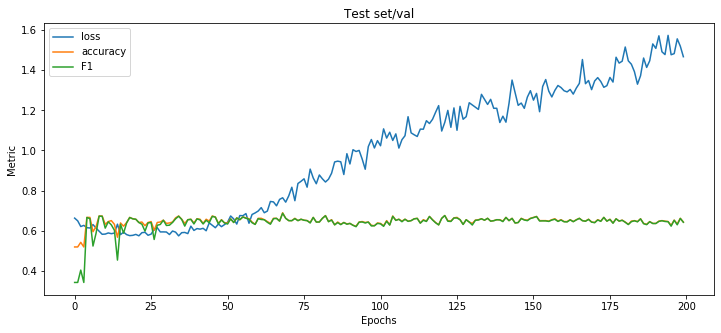

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.790960,0.673617,0.727588,0.678782,0.657834,0.672054
Confirmed,0.524533,0.669151,0.588081,0.678782,0.657834,0.672054


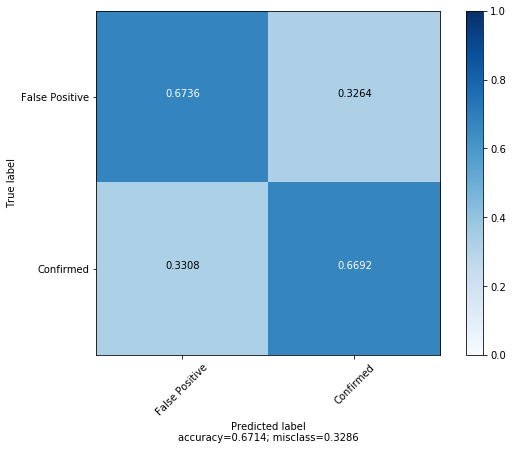

{'Precision raw': array([0.79096045, 0.52453271]),
 'Recall raw': array([0.67361668, 0.66915052]),
 'F1 raw': array([0.7275877, 0.5880812]),
 'F1 weighted': 0.6787822475587396,
 'F1 macro': 0.6578344526401204,
 'F1 micro': 0.6720542231491137,
 'Confusion Matrix': array([[840, 407],
        [222, 449]])}

In [28]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod2.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3840/3905 [============================>.] - ETA: 0s - loss: 10.9578 - acc: 0.6125

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
3905/3905 [==============================] - 14s 4ms/step - loss: 10.8524 - acc: 0.6149 - val_loss: 10.0742 - val_acc: 0.5184
Epoch 2/200
3905/3905 [==============================] - 9s 2ms/step - loss: 10.0450 - acc: 0.6438 - val_loss: 10.2772 - val_acc: 0.5184
Epoch 3/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.9064 - acc: 0.6364 - val_loss: 9.8006 - val_acc: 0.5184
Epoch 4/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.8956 - acc: 0.6361 - val_loss: 10.4617 - val_acc: 0.5184
Epoch 5/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.7660 - acc: 0.6361 - val_loss: 9.8982 - val_acc: 0.5184
Epoch 6/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.6208 - acc: 0.6466 - val_loss: 9.4486 - val_acc: 0.5161
Epoch 7/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.4163 - acc: 0.6433 - val_loss: 9.4548 - val_acc: 0.5184
Epoch 8/200
3905/3905 [=================

Epoch 36/200
3905/3905 [==============================] - 8s 2ms/step - loss: 8.0481 - acc: 0.7260 - val_loss: 8.4044 - val_acc: 0.6820
Epoch 37/200
3905/3905 [==============================] - 8s 2ms/step - loss: 7.9002 - acc: 0.7360 - val_loss: 8.5379 - val_acc: 0.6982
Epoch 38/200
3905/3905 [==============================] - 8s 2ms/step - loss: 7.8605 - acc: 0.7370 - val_loss: 8.6581 - val_acc: 0.6728
Epoch 39/200
3905/3905 [==============================] - 8s 2ms/step - loss: 7.8663 - acc: 0.7296 - val_loss: 8.7032 - val_acc: 0.6590
Epoch 40/200
3905/3905 [==============================] - 8s 2ms/step - loss: 7.8222 - acc: 0.7242 - val_loss: 9.1622 - val_acc: 0.6382
Epoch 41/200
3905/3905 [==============================] - 8s 2ms/step - loss: 8.0686 - acc: 0.7293 - val_loss: 9.2325 - val_acc: 0.6682
Epoch 42/200
3905/3905 [==============================] - 9s 2ms/step - loss: 7.8884 - acc: 0.7383 - val_loss: 8.7891 - val_acc: 0.6336
Epoch 43/200
3905/3905 [========================

3905/3905 [==============================] - 8s 2ms/step - loss: 6.0744 - acc: 0.8131 - val_loss: 10.3733 - val_acc: 0.6382
Epoch 71/200
3905/3905 [==============================] - 9s 2ms/step - loss: 6.0749 - acc: 0.8271 - val_loss: 10.4473 - val_acc: 0.6475
Epoch 72/200
3905/3905 [==============================] - 8s 2ms/step - loss: 5.5800 - acc: 0.8402 - val_loss: 11.7851 - val_acc: 0.6475
Epoch 73/200
3905/3905 [==============================] - 8s 2ms/step - loss: 5.6926 - acc: 0.8359 - val_loss: 11.4629 - val_acc: 0.6797
Epoch 74/200
3905/3905 [==============================] - 8s 2ms/step - loss: 5.9709 - acc: 0.8297 - val_loss: 10.6123 - val_acc: 0.6221
Epoch 75/200
3905/3905 [==============================] - 8s 2ms/step - loss: 5.6699 - acc: 0.8471 - val_loss: 10.6820 - val_acc: 0.6682
Epoch 76/200
3905/3905 [==============================] - 8s 2ms/step - loss: 5.4214 - acc: 0.8433 - val_loss: 11.5860 - val_acc: 0.6521
Epoch 77/200
3905/3905 [==============================

3905/3905 [==============================] - 8s 2ms/step - loss: 3.6415 - acc: 0.9111 - val_loss: 16.0217 - val_acc: 0.6682
Epoch 105/200
3905/3905 [==============================] - 7s 2ms/step - loss: 3.3600 - acc: 0.9214 - val_loss: 17.2902 - val_acc: 0.6636
Epoch 106/200
3905/3905 [==============================] - 8s 2ms/step - loss: 3.2922 - acc: 0.9155 - val_loss: 17.4068 - val_acc: 0.6613
Epoch 107/200
3905/3905 [==============================] - 8s 2ms/step - loss: 3.1828 - acc: 0.9183 - val_loss: 17.8342 - val_acc: 0.6452
Epoch 108/200
3905/3905 [==============================] - 9s 2ms/step - loss: 3.2760 - acc: 0.9201 - val_loss: 17.5084 - val_acc: 0.6336
Epoch 109/200
3905/3905 [==============================] - 8s 2ms/step - loss: 3.2809 - acc: 0.9224 - val_loss: 16.6955 - val_acc: 0.6544
Epoch 110/200
3905/3905 [==============================] - 8s 2ms/step - loss: 3.2117 - acc: 0.9268 - val_loss: 18.9807 - val_acc: 0.6544
Epoch 111/200
3905/3905 [=======================

3905/3905 [==============================] - 8s 2ms/step - loss: 2.5717 - acc: 0.9370 - val_loss: 22.6733 - val_acc: 0.6544
Epoch 139/200
3905/3905 [==============================] - 7s 2ms/step - loss: 2.3374 - acc: 0.9439 - val_loss: 22.7045 - val_acc: 0.6498
Epoch 140/200
3905/3905 [==============================] - 7s 2ms/step - loss: 2.0821 - acc: 0.9521 - val_loss: 24.2227 - val_acc: 0.6544
Epoch 141/200
3905/3905 [==============================] - 7s 2ms/step - loss: 2.1855 - acc: 0.9478 - val_loss: 25.1613 - val_acc: 0.6590
Epoch 142/200
3905/3905 [==============================] - 8s 2ms/step - loss: 2.1728 - acc: 0.9493 - val_loss: 25.0529 - val_acc: 0.6290
Epoch 143/200
3905/3905 [==============================] - 7s 2ms/step - loss: 2.2956 - acc: 0.9457 - val_loss: 26.1651 - val_acc: 0.6429
Epoch 144/200
3905/3905 [==============================] - 8s 2ms/step - loss: 2.0973 - acc: 0.9542 - val_loss: 23.4173 - val_acc: 0.6590
Epoch 145/200
3905/3905 [=======================

3905/3905 [==============================] - 7s 2ms/step - loss: 1.6093 - acc: 0.9644 - val_loss: 26.6275 - val_acc: 0.6429
Epoch 173/200
3905/3905 [==============================] - 8s 2ms/step - loss: 1.5208 - acc: 0.9649 - val_loss: 28.4887 - val_acc: 0.6682
Epoch 174/200
3905/3905 [==============================] - 8s 2ms/step - loss: 1.7576 - acc: 0.9624 - val_loss: 27.6787 - val_acc: 0.6429
Epoch 175/200
3905/3905 [==============================] - 9s 2ms/step - loss: 1.6467 - acc: 0.9659 - val_loss: 29.1346 - val_acc: 0.6498
Epoch 176/200
3905/3905 [==============================] - 7s 2ms/step - loss: 1.7435 - acc: 0.9590 - val_loss: 27.2488 - val_acc: 0.6636
Epoch 177/200
3905/3905 [==============================] - 7s 2ms/step - loss: 1.4774 - acc: 0.9680 - val_loss: 29.3810 - val_acc: 0.6498
Epoch 178/200
3905/3905 [==============================] - 8s 2ms/step - loss: 1.7093 - acc: 0.9606 - val_loss: 27.7109 - val_acc: 0.6359
Epoch 179/200
3905/3905 [=======================

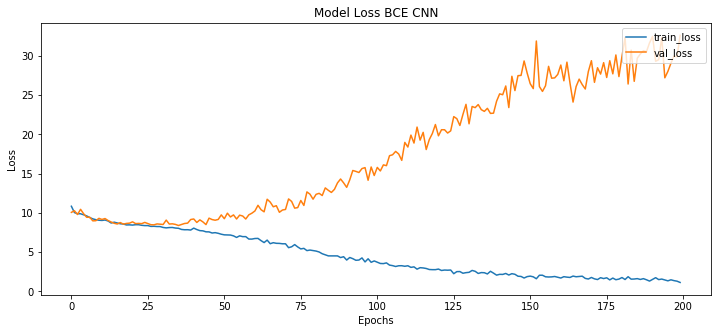

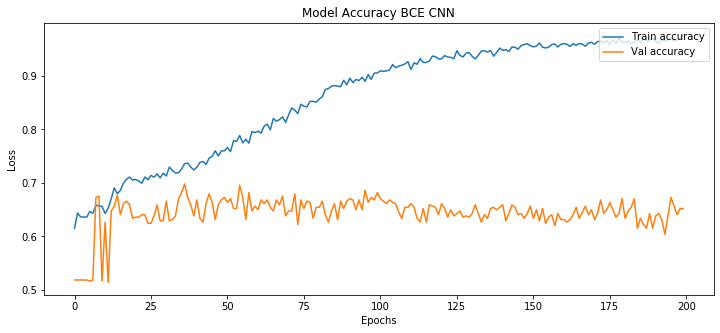

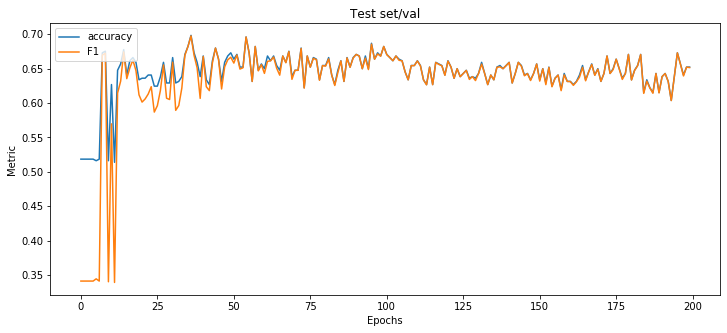

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.757626,0.736969,0.747154,0.677469,0.64756,0.675704
Confirmed,0.534752,0.561848,0.547965,0.677469,0.64756,0.675704


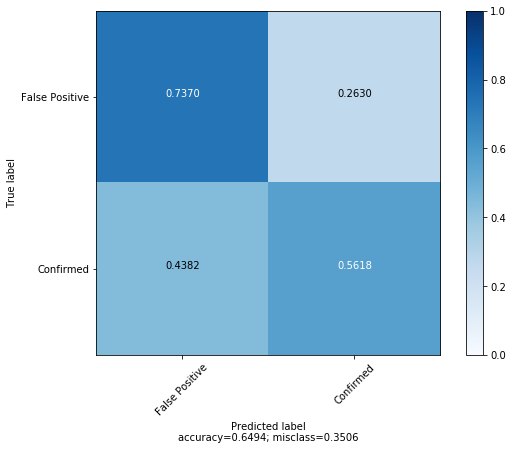

{'Precision raw': array([0.75762572, 0.53475177]),
 'Recall raw': array([0.73696872, 0.56184799]),
 'F1 raw': array([0.74715447, 0.54796512]),
 'F1 weighted': 0.6774693529924484,
 'F1 macro': 0.6475597939118927,
 'F1 micro': 0.67570385818561,
 'Confusion Matrix': array([[919, 328],
        [294, 377]])}

In [29]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod2.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

### GADF + GASF + Time (30)

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.6429 - acc: 0.6325 - val_loss: 0.6696 - val_acc: 0.5000
 - val_f1: 0.363469 
Epoch 2/200
3905/3905 [==============================] - 2s 405us/step - loss: 0.6071 - acc: 0.6364 - val_loss: 0.6375 - val_acc: 0.5138
 - val_f1: 0.387657 
Epoch 3/200
3905/3905 [==============================] - 2s 546us/step - loss: 0.5895 - acc: 0.6315 - val_loss: 0.6232 - val_acc: 0.5161
 - val_f1: 0.340426 
Epoch 4/200
3905/3905 [==============================] - 2s 545us/step - loss: 0.5811 - acc: 0.6405 - val_loss: 0.6194 - val_acc: 0.5323
 - val_f1: 0.422793 
Epoch 5/200
3905/3905 [==============================] - 2s 456us/step - loss: 0.5793 - acc: 0.6438 - val_loss: 0.6146 - val_acc: 0.5991
 - val_f1: 0.581888 
Epoch 6/200
3905/3905 [==============================] - 2s 601us/step - loss: 0.5771 - acc: 0.6533 - val_loss: 0.6189 - val_acc: 0.5392
 - val_f1: 0.443433 
Epoch 7

3905/3905 [==============================] - 2s 595us/step - loss: 0.1905 - acc: 0.9255 - val_loss: 1.1339 - val_acc: 0.5829
 - val_f1: 0.573380 
Epoch 104/200
3905/3905 [==============================] - 3s 656us/step - loss: 0.1848 - acc: 0.9319 - val_loss: 1.1424 - val_acc: 0.6083
 - val_f1: 0.596566 
Epoch 105/200
3905/3905 [==============================] - 2s 627us/step - loss: 0.1910 - acc: 0.9278 - val_loss: 1.1954 - val_acc: 0.6037
 - val_f1: 0.588263 
Epoch 106/200
3905/3905 [==============================] - 2s 583us/step - loss: 0.1882 - acc: 0.9260 - val_loss: 1.1658 - val_acc: 0.6083
 - val_f1: 0.600134 
Epoch 107/200
3905/3905 [==============================] - 2s 593us/step - loss: 0.1904 - acc: 0.9245 - val_loss: 1.1937 - val_acc: 0.6198
 - val_f1: 0.611632 
Epoch 108/200
3905/3905 [==============================] - 2s 587us/step - loss: 0.1849 - acc: 0.9293 - val_loss: 1.1430 - val_acc: 0.6037
 - val_f1: 0.597455 
Epoch 109/200
3905/3905 [=============================

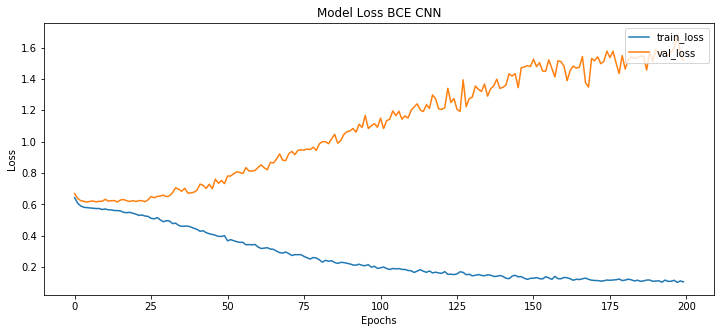

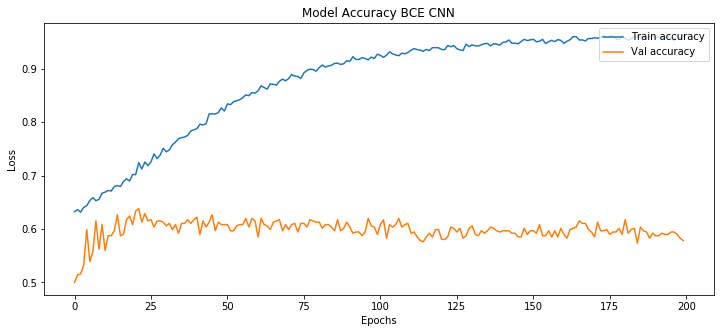

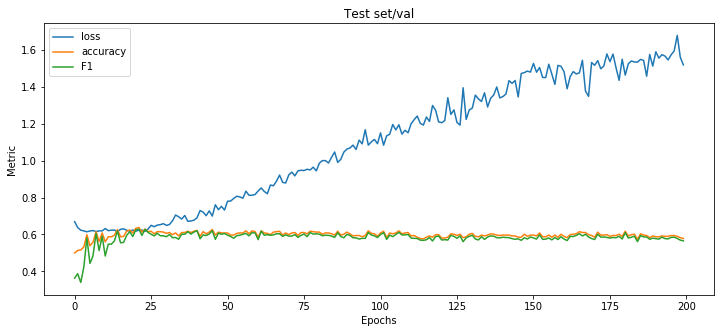

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.716912,0.781877,0.747986,0.649132,0.606703,0.657456
Confirmed,0.512545,0.426230,0.465419,0.649132,0.606703,0.657456


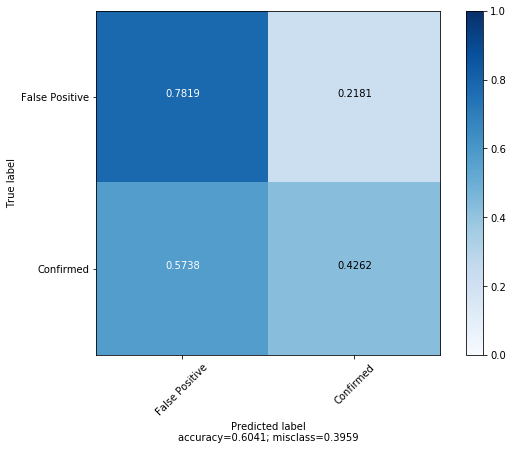

{'Precision raw': array([0.71691176, 0.5125448 ]),
 'Recall raw': array([0.7818765 , 0.42622951]),
 'F1 raw': array([0.74798619, 0.46541904]),
 'F1 weighted': 0.6491318852762143,
 'F1 macro': 0.6067026154469892,
 'F1 micro': 0.6574556830031283,
 'Confusion Matrix': array([[975, 272],
        [385, 286]])}

In [41]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 5s 1ms/step - loss: 10.6491 - acc: 0.6128 - val_loss: 9.9178 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 1s 383us/step - loss: 9.7166 - acc: 0.6356 - val_loss: 9.5173 - val_acc: 0.5046
 - val_f1: 0.351271 
Epoch 3/200
3905/3905 [==============================] - 2s 580us/step - loss: 9.4574 - acc: 0.6448 - val_loss: 9.3579 - val_acc: 0.6613
 - val_f1: 0.651428 
Epoch 4/200
3905/3905 [==============================] - 2s 469us/step - loss: 9.4364 - acc: 0.6412 - val_loss: 9.3769 - val_acc: 0.5161
 - val_f1: 0.352846 
Epoch 5/200
3905/3905 [==============================] - 2s 452us/step - loss: 9.3145 - acc: 0.6474 - val_loss: 9.2982 - val_acc: 0.5876
 - val_f1: 0.570290 
Epoch 6/200
3905/3905 [==============================] - 2s 530us/step - loss: 9.3196 - acc: 0.6510 - val_loss: 9.3227 - val_acc: 0.5438
 - val_f1: 0.474075 
Epoch 7/200
3905/3905 [==============================] - 1s 315us/step - loss: 9.2548 - acc: 0.6502 - val_loss: 9.3231 - val_acc: 0.5829
 - val_f1: 0.565489 
Epoch 8/200
3905/3905 [========

3905/3905 [==============================] - 2s 453us/step - loss: 2.9626 - acc: 0.9393 - val_loss: 20.2839 - val_acc: 0.6129
 - val_f1: 0.597082 
Epoch 105/200
3905/3905 [==============================] - 2s 477us/step - loss: 3.0834 - acc: 0.9293 - val_loss: 20.5406 - val_acc: 0.6106
 - val_f1: 0.591858 
Epoch 106/200
3905/3905 [==============================] - 2s 432us/step - loss: 2.7998 - acc: 0.9398 - val_loss: 19.5151 - val_acc: 0.6175
 - val_f1: 0.604058 
Epoch 107/200
3905/3905 [==============================] - 2s 516us/step - loss: 2.7584 - acc: 0.9411 - val_loss: 19.6149 - val_acc: 0.6037
 - val_f1: 0.589015 
Epoch 108/200
3905/3905 [==============================] - 2s 539us/step - loss: 3.0297 - acc: 0.9347 - val_loss: 21.5876 - val_acc: 0.5968
 - val_f1: 0.574641 
Epoch 109/200
3905/3905 [==============================] - 2s 400us/step - loss: 2.8206 - acc: 0.9355 - val_loss: 21.0591 - val_acc: 0.6129
 - val_f1: 0.597838 
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 2s 543us/step - loss: 1.9574 - acc: 0.9585 - val_loss: 25.3029 - val_acc: 0.6244
 - val_f1: 0.613489 
Epoch 156/200
3905/3905 [==============================] - 1s 365us/step - loss: 2.1764 - acc: 0.9567 - val_loss: 25.7086 - val_acc: 0.6221
 - val_f1: 0.605139 
Epoch 157/200
3905/3905 [==============================] - 1s 341us/step - loss: 2.2330 - acc: 0.9562 - val_loss: 26.4914 - val_acc: 0.6106
 - val_f1: 0.593505 
Epoch 158/200
3905/3905 [==============================] - 2s 512us/step - loss: 2.2952 - acc: 0.9526 - val_loss: 24.9645 - val_acc: 0.6014
 - val_f1: 0.583052 
Epoch 159/200
3905/3905 [==============================] - 2s 527us/step - loss: 1.9034 - acc: 0.9557 - val_loss: 26.1067 - val_acc: 0.5945
 - val_f1: 0.573607 
Epoch 160/200
3905/3905 [==============================] - 2s 457us/step - loss: 2.1059 - acc: 0.9542 - val_loss: 24.4906 - val_acc: 0.6037
 - val_f1: 0.590458 
Epoch 161/200
3905/3905 [=======================

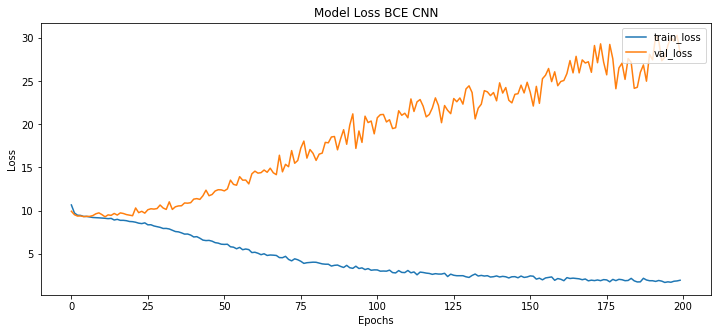

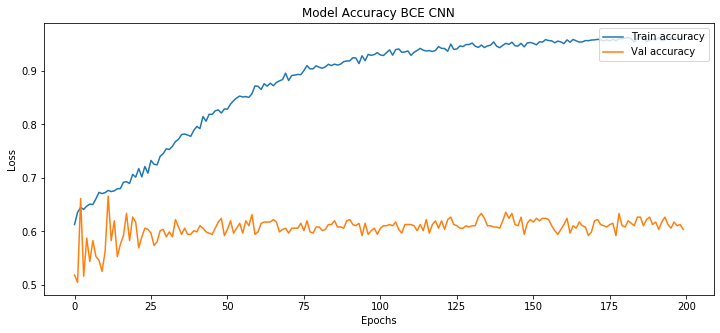

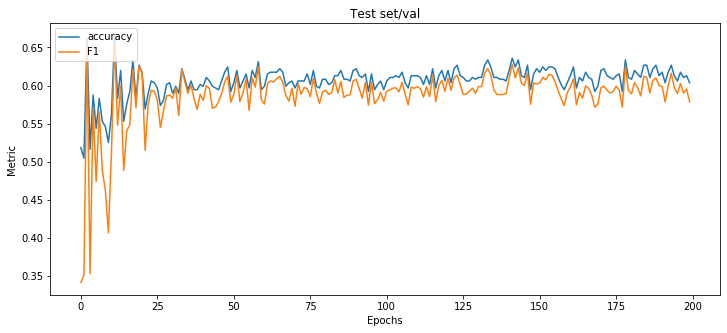

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.733086,0.790698,0.760802,0.670125,0.631205,0.676747
Confirmed,0.544503,0.464978,0.501608,0.670125,0.631205,0.676747


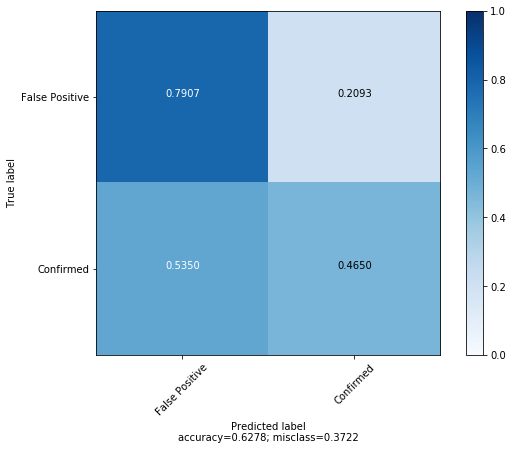

{'Precision raw': array([0.7330855 , 0.54450262]),
 'Recall raw': array([0.79069767, 0.46497765]),
 'F1 raw': array([0.76080247, 0.50160772]),
 'F1 weighted': 0.6701248473135527,
 'F1 macro': 0.6312050930888016,
 'F1 micro': 0.6767466110531803,
 'Confusion Matrix': array([[986, 261],
        [359, 312]])}

In [42]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

### GADF + GASF + MTF + Time (30) -- todo

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.6434 - acc: 0.6287 - val_loss: 0.6491 - val_acc: 0.5392
 - val_f1: 0.485648 
Epoch 2/200
3905/3905 [==============================] - 2s 561us/step - loss: 0.5997 - acc: 0.6343 - val_loss: 0.6219 - val_acc: 0.5323
 - val_f1: 0.404535 
Epoch 3/200
3905/3905 [==============================] - 2s 587us/step - loss: 0.5756 - acc: 0.6448 - val_loss: 0.5983 - val_acc: 0.6567
 - val_f1: 0.655715 
Epoch 4/200
3905/3905 [==============================] - 2s 455us/step - loss: 0.5669 - acc: 0.6407 - val_loss: 0.5878 - val_acc: 0.6774
 - val_f1: 0.677248 
Epoch 5/200
3905/3905 [==============================] - 2s 529us/step - loss: 0.5585 - acc: 0.6520 - val_loss: 0.5911 - val_acc: 0.5783
 - val_f1: 0.538853 
Epoch 6/200
3905/3905 [==============================] - 2s 510us/step - loss: 0.5502 - acc: 0.6609 - val_loss: 0.5846 - val_acc: 0.6452
 - val_f1: 0.638709 
Epoch 7

3905/3905 [==============================] - 3s 652us/step - loss: 0.2009 - acc: 0.9214 - val_loss: 0.9271 - val_acc: 0.6336
 - val_f1: 0.627210 
Epoch 104/200
3905/3905 [==============================] - 2s 633us/step - loss: 0.2022 - acc: 0.9173 - val_loss: 0.9266 - val_acc: 0.6221
 - val_f1: 0.610165 
Epoch 105/200
3905/3905 [==============================] - 2s 565us/step - loss: 0.2026 - acc: 0.9157 - val_loss: 0.9566 - val_acc: 0.6290
 - val_f1: 0.619975 
Epoch 106/200
3905/3905 [==============================] - 2s 565us/step - loss: 0.1916 - acc: 0.9229 - val_loss: 0.9523 - val_acc: 0.6290
 - val_f1: 0.620520 
Epoch 107/200
3905/3905 [==============================] - 3s 719us/step - loss: 0.1976 - acc: 0.9150 - val_loss: 0.9848 - val_acc: 0.6267
 - val_f1: 0.612910 
Epoch 108/200
3905/3905 [==============================] - 3s 663us/step - loss: 0.1983 - acc: 0.9211 - val_loss: 0.9308 - val_acc: 0.6429
 - val_f1: 0.637028 
Epoch 109/200
3905/3905 [=============================

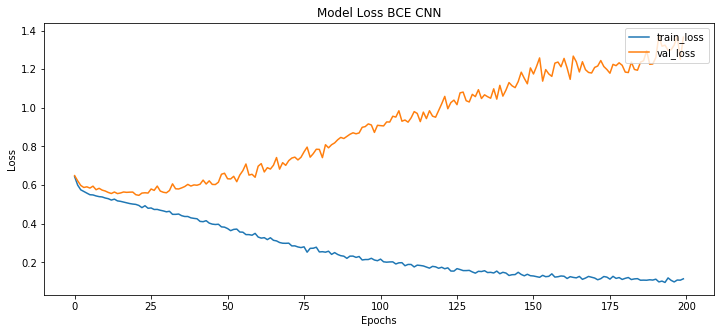

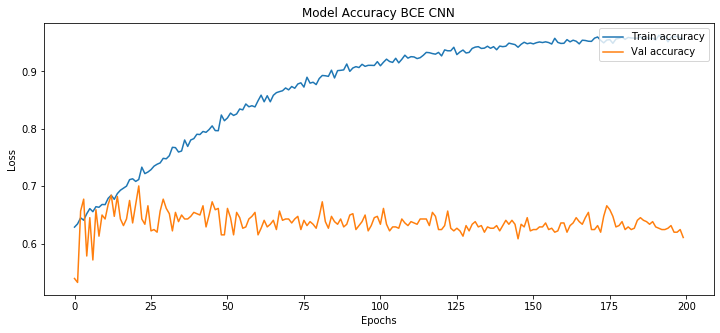

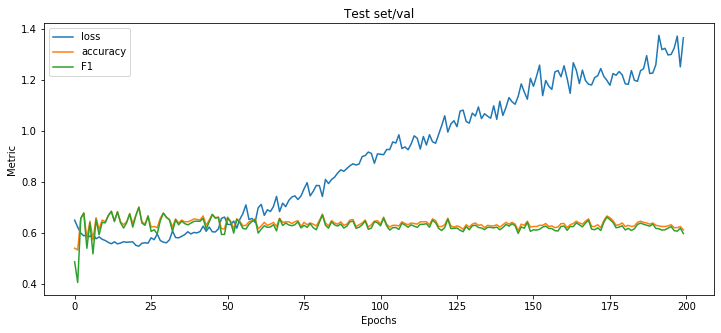

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.81639,0.631115,0.711895,0.675548,0.659948,0.667883
Confirmed,0.51782,0.736215,0.608000,0.675548,0.659948,0.667883


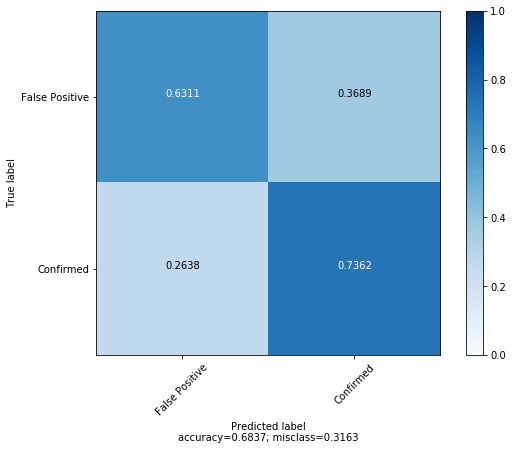

{'Precision raw': array([0.81639004, 0.51781971]),
 'Recall raw': array([0.63111468, 0.73621461]),
 'F1 raw': array([0.71189507, 0.608     ]),
 'F1 weighted': 0.6755480460999581,
 'F1 macro': 0.6599475350520126,
 'F1 micro': 0.6678832116788321,
 'Confusion Matrix': array([[787, 460],
        [177, 494]])}

In [45]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 6s 1ms/step - loss: 10.5490 - acc: 0.6241 - val_loss: 9.7730 - val_acc: 0.5115
 - val_f1: 0.342593 
Epoch 2/200
3905/3905 [==============================] - 2s 567us/step - loss: 9.5622 - acc: 0.6356 - val_loss: 9.2378 - val_acc: 0.5323
 - val_f1: 0.397927 
Epoch 3/200
3905/3905 [==============================] - 3s 744us/step - loss: 9.1907 - acc: 0.6438 - val_loss: 9.0656 - val_acc: 0.5968
 - val_f1: 0.584362 
Epoch 4/200
3905/3905 [==============================] - 3s 668us/step - loss: 9.0295 - acc: 0.6530 - val_loss: 8.8359 - val_acc: 0.6774
 - val_f1: 0.674656 
Epoch 5/200
3905/3905 [==============================] - 2s 607us/step - loss: 8.9885 - acc: 0.6407 - val_loss: 8.9669 - val_acc: 0.6014
 - val_f1: 0.587722 
Epoch 6/200
3905/3905 [==============================] - 2s 541us/step - loss: 8.8240 - acc: 0.6456 - val_loss: 8.7688 - val_acc: 0.7074
 - val_f1: 0.707185 
Epoch 

3905/3905 [==============================] - 2s 406us/step - loss: 2.9553 - acc: 0.9273 - val_loss: 17.0138 - val_acc: 0.6336
 - val_f1: 0.630342 
Epoch 104/200
3905/3905 [==============================] - 2s 477us/step - loss: 2.8978 - acc: 0.9303 - val_loss: 16.9890 - val_acc: 0.6175
 - val_f1: 0.604058 
Epoch 105/200
3905/3905 [==============================] - 2s 416us/step - loss: 3.0411 - acc: 0.9268 - val_loss: 17.2505 - val_acc: 0.6244
 - val_f1: 0.616855 
Epoch 106/200
3905/3905 [==============================] - 2s 454us/step - loss: 2.8486 - acc: 0.9314 - val_loss: 17.1592 - val_acc: 0.6244
 - val_f1: 0.610869 
Epoch 107/200
3905/3905 [==============================] - 2s 579us/step - loss: 2.9137 - acc: 0.9324 - val_loss: 17.3477 - val_acc: 0.6129
 - val_f1: 0.603161 
Epoch 108/200
3905/3905 [==============================] - 2s 633us/step - loss: 2.9680 - acc: 0.9350 - val_loss: 16.1832 - val_acc: 0.6544
 - val_f1: 0.651983 
Epoch 109/200
3905/3905 [=======================

3905/3905 [==============================] - 2s 590us/step - loss: 2.0739 - acc: 0.9503 - val_loss: 23.1418 - val_acc: 0.5991
 - val_f1: 0.590166 
Epoch 155/200
3905/3905 [==============================] - 2s 574us/step - loss: 2.1126 - acc: 0.9490 - val_loss: 24.1071 - val_acc: 0.5876
 - val_f1: 0.573423 
Epoch 156/200
3905/3905 [==============================] - 2s 598us/step - loss: 2.1693 - acc: 0.9519 - val_loss: 21.9737 - val_acc: 0.6175
 - val_f1: 0.612367 
Epoch 157/200
3905/3905 [==============================] - 2s 630us/step - loss: 2.0225 - acc: 0.9562 - val_loss: 23.8731 - val_acc: 0.6014
 - val_f1: 0.587722 
Epoch 158/200
3905/3905 [==============================] - 2s 564us/step - loss: 1.8839 - acc: 0.9624 - val_loss: 23.0945 - val_acc: 0.6152
 - val_f1: 0.607453 
Epoch 159/200
3905/3905 [==============================] - 3s 675us/step - loss: 2.0519 - acc: 0.9534 - val_loss: 22.7048 - val_acc: 0.6152
 - val_f1: 0.606925 
Epoch 160/200
3905/3905 [=======================

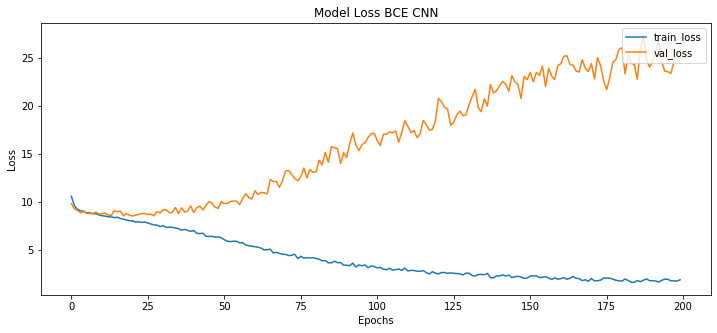

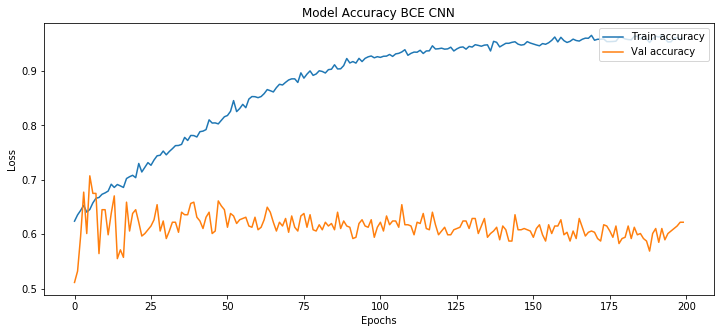

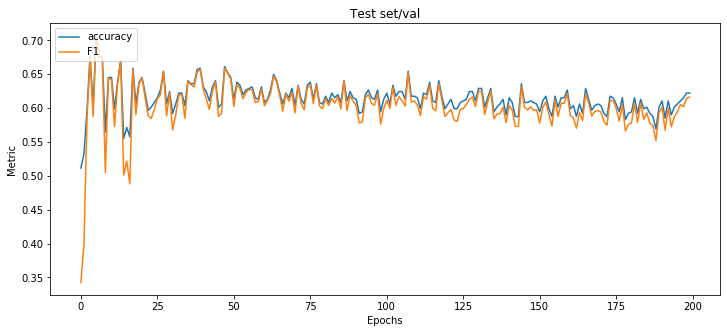

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.773205,0.708099,0.739221,0.679829,0.654338,0.675182
Confirmed,0.530928,0.614009,0.569454,0.679829,0.654338,0.675182


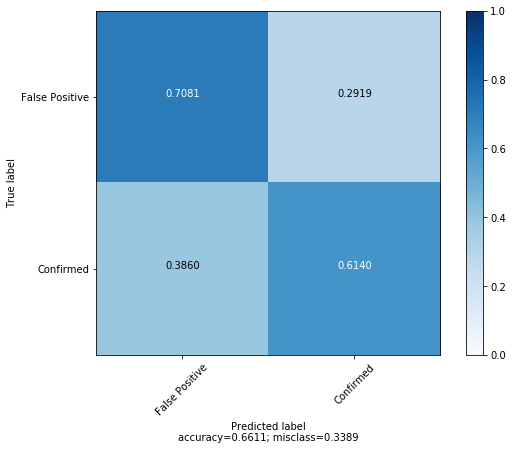

{'Precision raw': array([0.7732049 , 0.53092784]),
 'Recall raw': array([0.70809944, 0.61400894]),
 'F1 raw': array([0.73922143, 0.56945404]),
 'F1 weighted': 0.6798293993261145,
 'F1 macro': 0.6543377372042964,
 'F1 micro': 0.6751824817518248,
 'Confusion Matrix': array([[883, 364],
        [259, 412]])}

In [46]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

### tamaño 64

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3840/3905 [============================>.] - ETA: 0s - loss: 0.6587 - acc: 0.6312

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
3905/3905 [==============================] - 16s 4ms/step - loss: 0.6585 - acc: 0.6315 - val_loss: 0.6611 - val_acc: 0.5184
Epoch 2/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.6207 - acc: 0.6410 - val_loss: 0.6577 - val_acc: 0.5184
Epoch 3/200
3905/3905 [==============================] - 9s 2ms/step - loss: 0.6033 - acc: 0.6384 - val_loss: 0.6394 - val_acc: 0.5184
Epoch 4/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.5882 - acc: 0.6538 - val_loss: 0.6131 - val_acc: 0.5991
Epoch 5/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.5820 - acc: 0.6499 - val_loss: 0.6155 - val_acc: 0.5276
Epoch 6/200
3905/3905 [==============================] - 9s 2ms/step - loss: 0.5761 - acc: 0.6535 - val_loss: 0.6104 - val_acc: 0.6244
Epoch 7/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.5632 - acc: 0.6627 - val_loss: 0.5937 - val_acc: 0.6613
Epoch 8/200
3905/3905 [======================

Epoch 36/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.4949 - acc: 0.7327 - val_loss: 0.5651 - val_acc: 0.6567
Epoch 37/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.4820 - acc: 0.7370 - val_loss: 0.5967 - val_acc: 0.6290
Epoch 38/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.4757 - acc: 0.7391 - val_loss: 0.5703 - val_acc: 0.6682
Epoch 39/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.4733 - acc: 0.7434 - val_loss: 0.5946 - val_acc: 0.6267
Epoch 40/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.4698 - acc: 0.7493 - val_loss: 0.5814 - val_acc: 0.6797
Epoch 41/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.4627 - acc: 0.7488 - val_loss: 0.6008 - val_acc: 0.6429
Epoch 42/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.4626 - acc: 0.7503 - val_loss: 0.5917 - val_acc: 0.6590
Epoch 43/200
3905/3905 [========================

3905/3905 [==============================] - 9s 2ms/step - loss: 0.3438 - acc: 0.8374 - val_loss: 0.7677 - val_acc: 0.6429
Epoch 71/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.3147 - acc: 0.8502 - val_loss: 0.8321 - val_acc: 0.6567
Epoch 72/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.3201 - acc: 0.8471 - val_loss: 0.8082 - val_acc: 0.6475
Epoch 73/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.3195 - acc: 0.8520 - val_loss: 0.8198 - val_acc: 0.6590
Epoch 74/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.3150 - acc: 0.8602 - val_loss: 0.8447 - val_acc: 0.6336
Epoch 75/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.3114 - acc: 0.8609 - val_loss: 0.7724 - val_acc: 0.6475
Epoch 76/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.3047 - acc: 0.8602 - val_loss: 0.7721 - val_acc: 0.6590
Epoch 77/200
3905/3905 [==============================] - 8s 

Epoch 105/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.1896 - acc: 0.9214 - val_loss: 1.1878 - val_acc: 0.6429
Epoch 106/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1932 - acc: 0.9201 - val_loss: 1.0674 - val_acc: 0.6382
Epoch 107/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.1859 - acc: 0.9227 - val_loss: 1.1521 - val_acc: 0.6429
Epoch 108/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1841 - acc: 0.9222 - val_loss: 1.2439 - val_acc: 0.6267
Epoch 109/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1768 - acc: 0.9262 - val_loss: 1.1874 - val_acc: 0.6475
Epoch 110/200
3905/3905 [==============================] - 9s 2ms/step - loss: 0.1601 - acc: 0.9339 - val_loss: 1.2591 - val_acc: 0.6221
Epoch 111/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1703 - acc: 0.9324 - val_loss: 1.2419 - val_acc: 0.6313
Epoch 112/200
3905/3905 [================

3905/3905 [==============================] - 8s 2ms/step - loss: 0.1191 - acc: 0.9516 - val_loss: 1.5720 - val_acc: 0.5991
Epoch 140/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1260 - acc: 0.9508 - val_loss: 1.4832 - val_acc: 0.6267
Epoch 141/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1330 - acc: 0.9472 - val_loss: 1.4278 - val_acc: 0.6406
Epoch 142/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1300 - acc: 0.9544 - val_loss: 1.3756 - val_acc: 0.6382
Epoch 143/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.1072 - acc: 0.9601 - val_loss: 1.4552 - val_acc: 0.6406
Epoch 144/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1150 - acc: 0.9544 - val_loss: 1.5188 - val_acc: 0.6359
Epoch 145/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1178 - acc: 0.9529 - val_loss: 1.3819 - val_acc: 0.6567
Epoch 146/200
3905/3905 [==============================

3905/3905 [==============================] - 8s 2ms/step - loss: 0.1011 - acc: 0.9603 - val_loss: 1.6134 - val_acc: 0.6106
Epoch 174/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.0998 - acc: 0.9575 - val_loss: 1.5340 - val_acc: 0.6244
Epoch 175/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.0854 - acc: 0.9695 - val_loss: 1.6527 - val_acc: 0.6267
Epoch 176/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.0834 - acc: 0.9670 - val_loss: 1.6123 - val_acc: 0.6313
Epoch 177/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.0950 - acc: 0.9652 - val_loss: 1.5308 - val_acc: 0.6659
Epoch 178/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.1000 - acc: 0.9613 - val_loss: 1.4542 - val_acc: 0.6382
Epoch 179/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.0998 - acc: 0.9657 - val_loss: 1.5068 - val_acc: 0.6313
Epoch 180/200
3905/3905 [==============================

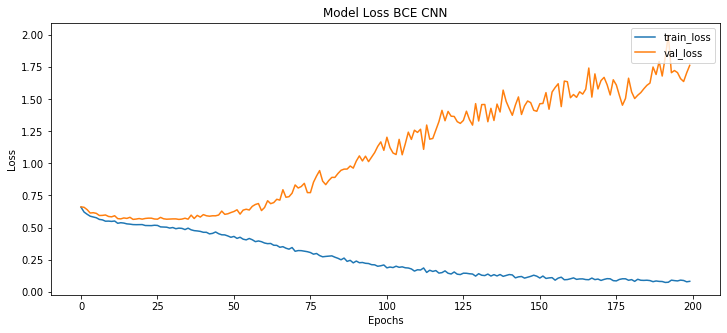

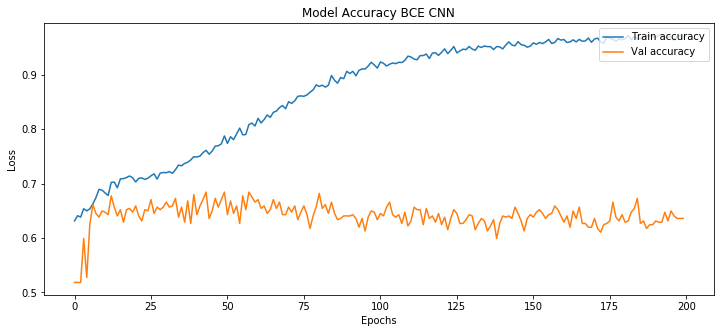

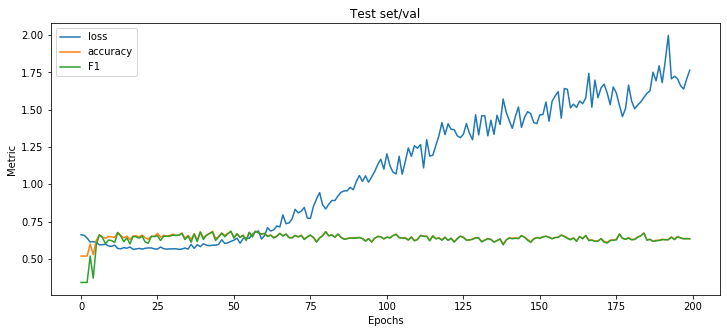

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.793103,0.645549,0.711760,0.667682,0.648764,0.660063
Confirmed,0.510520,0.687034,0.585769,0.667682,0.648764,0.660063


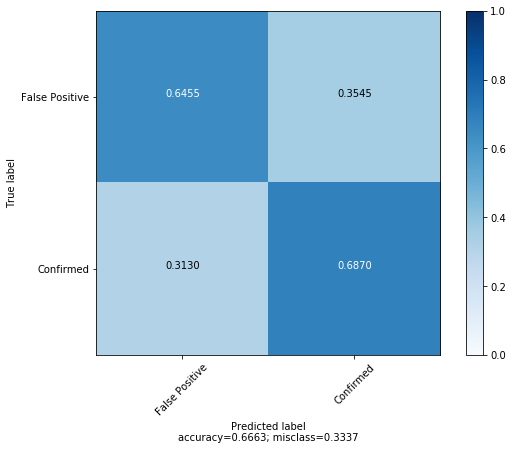

{'Precision raw': array([0.79310345, 0.51052049]),
 'Recall raw': array([0.64554932, 0.68703428]),
 'F1 raw': array([0.7117595 , 0.58576874]),
 'F1 weighted': 0.6676824444657573,
 'F1 macro': 0.6487641234607016,
 'F1 micro': 0.6600625651720542,
 'Confusion Matrix': array([[805, 442],
        [210, 461]])}

In [36]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod2.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3840/3905 [============================>.] - ETA: 0s - loss: 10.7269 - acc: 0.6211

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
3905/3905 [==============================] - 17s 4ms/step - loss: 10.6338 - acc: 0.6215 - val_loss: 9.7962 - val_acc: 0.5184
Epoch 2/200
3905/3905 [==============================] - 8s 2ms/step - loss: 10.0799 - acc: 0.6338 - val_loss: 10.1814 - val_acc: 0.5184
Epoch 3/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.8077 - acc: 0.6417 - val_loss: 9.7386 - val_acc: 0.5184
Epoch 4/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.7295 - acc: 0.6382 - val_loss: 10.0082 - val_acc: 0.5184
Epoch 5/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.5042 - acc: 0.6471 - val_loss: 9.3458 - val_acc: 0.5138
Epoch 6/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.3525 - acc: 0.6461 - val_loss: 9.3083 - val_acc: 0.5438
Epoch 7/200
3905/3905 [==============================] - 8s 2ms/step - loss: 9.2787 - acc: 0.6343 - val_loss: 9.2986 - val_acc: 0.5184
Epoch 8/200
3905/3905 [==================

Epoch 36/200
3905/3905 [==============================] - 9s 2ms/step - loss: 7.8916 - acc: 0.7239 - val_loss: 9.5184 - val_acc: 0.6313
Epoch 37/200
3905/3905 [==============================] - 8s 2ms/step - loss: 7.8851 - acc: 0.7193 - val_loss: 9.1667 - val_acc: 0.6313
Epoch 38/200
3905/3905 [==============================] - 8s 2ms/step - loss: 7.9126 - acc: 0.7239 - val_loss: 9.3285 - val_acc: 0.6728
Epoch 39/200
3905/3905 [==============================] - 8s 2ms/step - loss: 7.8642 - acc: 0.7273 - val_loss: 9.0331 - val_acc: 0.6221
Epoch 40/200
3905/3905 [==============================] - 8s 2ms/step - loss: 7.7703 - acc: 0.7234 - val_loss: 10.2258 - val_acc: 0.6544
Epoch 41/200
3905/3905 [==============================] - 9s 2ms/step - loss: 7.8241 - acc: 0.7242 - val_loss: 8.9275 - val_acc: 0.6106
Epoch 42/200
3905/3905 [==============================] - 8s 2ms/step - loss: 7.9157 - acc: 0.7332 - val_loss: 9.4080 - val_acc: 0.6406
Epoch 43/200
3905/3905 [=======================

3905/3905 [==============================] - 8s 2ms/step - loss: 6.1431 - acc: 0.8182 - val_loss: 11.3120 - val_acc: 0.6567
Epoch 71/200
3905/3905 [==============================] - 7s 2ms/step - loss: 5.9450 - acc: 0.8123 - val_loss: 10.8264 - val_acc: 0.6475
Epoch 72/200
3905/3905 [==============================] - 8s 2ms/step - loss: 5.8181 - acc: 0.8200 - val_loss: 12.3803 - val_acc: 0.6636
Epoch 73/200
3905/3905 [==============================] - 8s 2ms/step - loss: 6.1485 - acc: 0.8008 - val_loss: 12.3373 - val_acc: 0.6336
Epoch 74/200
3905/3905 [==============================] - 8s 2ms/step - loss: 6.0407 - acc: 0.8128 - val_loss: 11.4226 - val_acc: 0.6060
Epoch 75/200
3905/3905 [==============================] - 8s 2ms/step - loss: 6.0978 - acc: 0.8133 - val_loss: 11.9541 - val_acc: 0.6406
Epoch 76/200
3905/3905 [==============================] - 8s 2ms/step - loss: 5.7590 - acc: 0.8307 - val_loss: 12.1234 - val_acc: 0.6544
Epoch 77/200
3905/3905 [==============================

3905/3905 [==============================] - 8s 2ms/step - loss: 3.7408 - acc: 0.9029 - val_loss: 15.8031 - val_acc: 0.6498
Epoch 105/200
3905/3905 [==============================] - 7s 2ms/step - loss: 4.2361 - acc: 0.8866 - val_loss: 16.6253 - val_acc: 0.6659
Epoch 106/200
3905/3905 [==============================] - 8s 2ms/step - loss: 4.2940 - acc: 0.8832 - val_loss: 14.5635 - val_acc: 0.6889
Epoch 107/200
3905/3905 [==============================] - 8s 2ms/step - loss: 3.8270 - acc: 0.8991 - val_loss: 16.3997 - val_acc: 0.6682
Epoch 108/200
3905/3905 [==============================] - 7s 2ms/step - loss: 3.7745 - acc: 0.9027 - val_loss: 13.6453 - val_acc: 0.6475
Epoch 109/200
3905/3905 [==============================] - 9s 2ms/step - loss: 3.8223 - acc: 0.8991 - val_loss: 14.6914 - val_acc: 0.6682
Epoch 110/200
3905/3905 [==============================] - 8s 2ms/step - loss: 3.7169 - acc: 0.9042 - val_loss: 16.0543 - val_acc: 0.6705
Epoch 111/200
3905/3905 [=======================

3905/3905 [==============================] - 9s 2ms/step - loss: 2.3260 - acc: 0.9475 - val_loss: 22.4233 - val_acc: 0.6590
Epoch 139/200
3905/3905 [==============================] - 8s 2ms/step - loss: 2.8307 - acc: 0.9367 - val_loss: 23.3013 - val_acc: 0.6590
Epoch 140/200
3905/3905 [==============================] - 8s 2ms/step - loss: 2.3675 - acc: 0.9406 - val_loss: 22.3640 - val_acc: 0.6475
Epoch 141/200
3905/3905 [==============================] - 8s 2ms/step - loss: 2.8712 - acc: 0.9337 - val_loss: 20.0678 - val_acc: 0.6567
Epoch 142/200
3905/3905 [==============================] - 8s 2ms/step - loss: 2.7310 - acc: 0.9373 - val_loss: 19.4596 - val_acc: 0.6590
Epoch 143/200
3905/3905 [==============================] - 8s 2ms/step - loss: 2.4337 - acc: 0.9449 - val_loss: 21.6666 - val_acc: 0.6452
Epoch 144/200
3905/3905 [==============================] - 8s 2ms/step - loss: 2.2589 - acc: 0.9462 - val_loss: 21.6654 - val_acc: 0.6728
Epoch 145/200
3905/3905 [=======================

3905/3905 [==============================] - 7s 2ms/step - loss: 1.8621 - acc: 0.9608 - val_loss: 25.3841 - val_acc: 0.6613
Epoch 173/200
3905/3905 [==============================] - 7s 2ms/step - loss: 2.1162 - acc: 0.9526 - val_loss: 25.2368 - val_acc: 0.6544
Epoch 174/200
3905/3905 [==============================] - 7s 2ms/step - loss: 1.9078 - acc: 0.9560 - val_loss: 22.5760 - val_acc: 0.6613
Epoch 175/200
3905/3905 [==============================] - 8s 2ms/step - loss: 1.9207 - acc: 0.9590 - val_loss: 25.2096 - val_acc: 0.6636
Epoch 176/200
3905/3905 [==============================] - 8s 2ms/step - loss: 2.0756 - acc: 0.9460 - val_loss: 23.5426 - val_acc: 0.6682
Epoch 177/200
3905/3905 [==============================] - 8s 2ms/step - loss: 1.8954 - acc: 0.9549 - val_loss: 25.1372 - val_acc: 0.6521
Epoch 178/200
3905/3905 [==============================] - 7s 2ms/step - loss: 1.6011 - acc: 0.9613 - val_loss: 28.3070 - val_acc: 0.6498
Epoch 179/200
3905/3905 [=======================

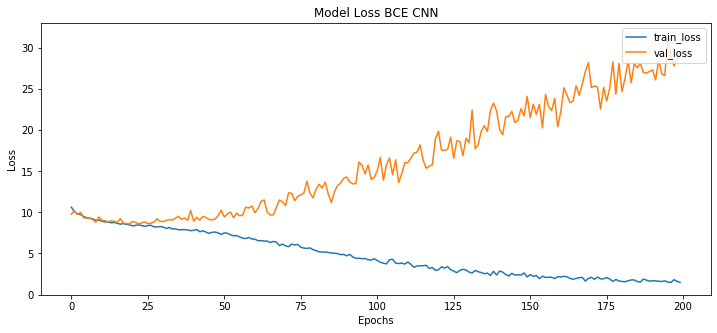

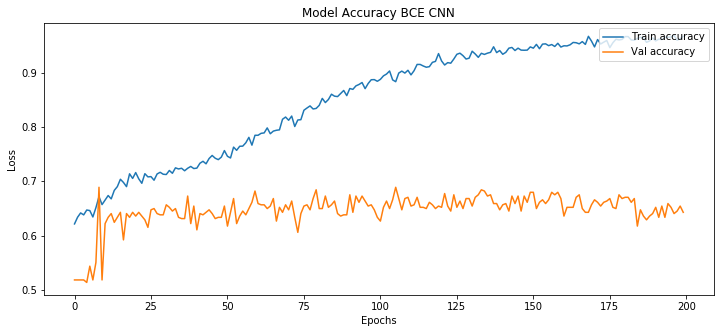

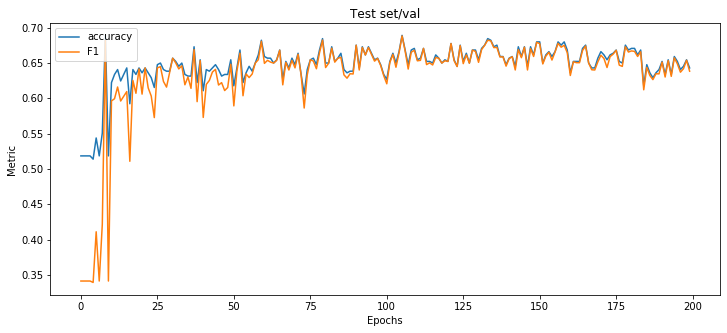

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.781852,0.684042,0.729683,0.676654,0.653894,0.67049
Confirmed,0.523579,0.645306,0.578104,0.676654,0.653894,0.67049


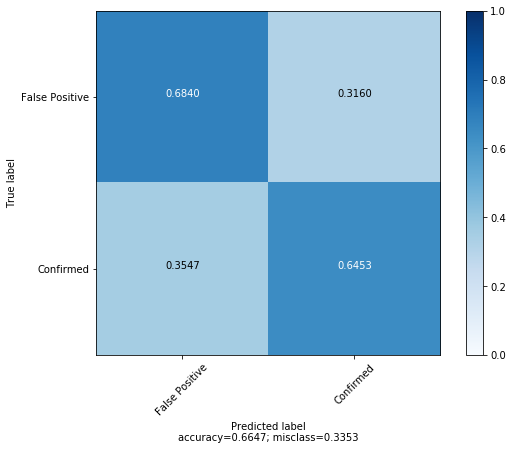

{'Precision raw': array([0.78185151, 0.5235792 ]),
 'Recall raw': array([0.6840417 , 0.64530551]),
 'F1 raw': array([0.72968349, 0.57810414]),
 'F1 weighted': 0.6766544261742633,
 'F1 macro': 0.6538938145071672,
 'F1 micro': 0.670490093847758,
 'Confusion Matrix': array([[853, 394],
        [238, 433]])}

In [37]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod2.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

## data aug del mejor

### GADF + GASF + MTF(64)

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7808/7810 [============================>.] - ETA: 0s - loss: 0.6411 - acc: 0.6393

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.350785 
7810/7810 [==============================] - 26s 3ms/step - loss: 0.6411 - acc: 0.6392 - val_loss: 0.6452 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.6186 - acc: 0.6399 - val_loss: 0.6414 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.6017 - acc: 0.6389 - val_loss: 0.6163 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.5796 - acc: 0.6383 - val_loss: 0.6117 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.5709 - acc: 0.6483 - val_loss: 0.6063 - val_acc: 0.6624
Epoch 6/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.5647 - acc: 0.6604 - val_loss: 0.5985 - val_acc: 0.6221
Epoch 7/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.5601 - acc: 0.6656 - val_loss: 0.5866 - val_acc: 0.6475
Epoch 8/200
7810/7810 [================

Epoch 36/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.5364 - acc: 0.6859 - val_loss: 0.5429 - val_acc: 0.6613
Epoch 37/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.5041 - acc: 0.7170 - val_loss: 0.5467 - val_acc: 0.6624
Epoch 38/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.4946 - acc: 0.7216 - val_loss: 0.5405 - val_acc: 0.6624
Epoch 39/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4993 - acc: 0.7205 - val_loss: 0.5435 - val_acc: 0.6694
Epoch 40/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.4985 - acc: 0.7227 - val_loss: 0.5350 - val_acc: 0.6763
Epoch 41/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.4865 - acc: 0.7234 - val_loss: 0.5329 - val_acc: 0.6797
Epoch 42/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.4836 - acc: 0.7271 - val_loss: 0.5366 - val_acc: 0.6740
Epoch 43/200
7810/7810 [=================

7810/7810 [==============================] - 17s 2ms/step - loss: 0.4364 - acc: 0.7671 - val_loss: 0.5289 - val_acc: 0.7074
Epoch 71/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4403 - acc: 0.7648 - val_loss: 0.5208 - val_acc: 0.7108
Epoch 72/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.4360 - acc: 0.7627 - val_loss: 0.5189 - val_acc: 0.7131
Epoch 73/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.4286 - acc: 0.7721 - val_loss: 0.5213 - val_acc: 0.7074
Epoch 74/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4333 - acc: 0.7663 - val_loss: 0.5262 - val_acc: 0.7016
Epoch 75/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.4236 - acc: 0.7691 - val_loss: 0.5283 - val_acc: 0.7131
Epoch 76/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4212 - acc: 0.7777 - val_loss: 0.5150 - val_acc: 0.7154
Epoch 77/200
7810/7810 [==============================

7810/7810 [==============================] - 16s 2ms/step - loss: 0.3764 - acc: 0.8072 - val_loss: 0.5233 - val_acc: 0.7154
Epoch 105/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.3850 - acc: 0.8026 - val_loss: 0.5181 - val_acc: 0.7097
Epoch 106/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.3682 - acc: 0.8127 - val_loss: 0.4986 - val_acc: 0.7281
Epoch 107/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.3692 - acc: 0.8125 - val_loss: 0.5104 - val_acc: 0.7189
Epoch 108/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.3645 - acc: 0.8129 - val_loss: 0.5023 - val_acc: 0.7235
Epoch 109/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.3686 - acc: 0.8081 - val_loss: 0.5020 - val_acc: 0.7247
Epoch 110/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.3620 - acc: 0.8178 - val_loss: 0.5402 - val_acc: 0.7212
Epoch 111/200
7810/7810 [=======================

7810/7810 [==============================] - 17s 2ms/step - loss: 0.3196 - acc: 0.8453 - val_loss: 0.5101 - val_acc: 0.7408
Epoch 139/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.3171 - acc: 0.8448 - val_loss: 0.4951 - val_acc: 0.7350
Epoch 140/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.3539 - acc: 0.8219 - val_loss: 0.5089 - val_acc: 0.7327
Epoch 141/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.3213 - acc: 0.8437 - val_loss: 0.5190 - val_acc: 0.7224
Epoch 142/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.3089 - acc: 0.8472 - val_loss: 0.5246 - val_acc: 0.7477
Epoch 143/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.3805 - acc: 0.8077 - val_loss: 0.4962 - val_acc: 0.7408
Epoch 144/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.3202 - acc: 0.8461 - val_loss: 0.5254 - val_acc: 0.7200
Epoch 145/200
7810/7810 [=======================

7810/7810 [==============================] - 17s 2ms/step - loss: 0.2775 - acc: 0.8693 - val_loss: 0.5432 - val_acc: 0.7454
Epoch 173/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.3131 - acc: 0.8516 - val_loss: 0.4935 - val_acc: 0.7373
Epoch 174/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.2732 - acc: 0.8739 - val_loss: 0.5519 - val_acc: 0.7396
Epoch 175/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.2707 - acc: 0.8786 - val_loss: 0.5483 - val_acc: 0.7442
Epoch 176/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.2806 - acc: 0.8703 - val_loss: 0.5375 - val_acc: 0.7419
Epoch 177/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.2686 - acc: 0.8729 - val_loss: 0.5127 - val_acc: 0.7431
Epoch 178/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.2830 - acc: 0.8659 - val_loss: 0.5298 - val_acc: 0.7454
Epoch 179/200
7810/7810 [=======================

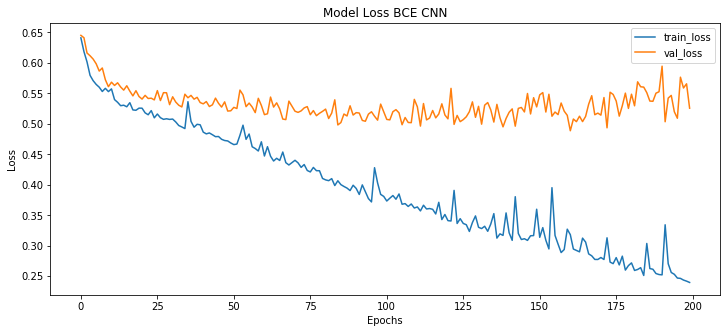

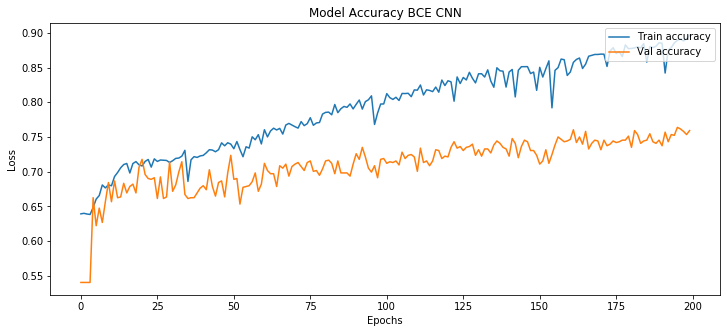

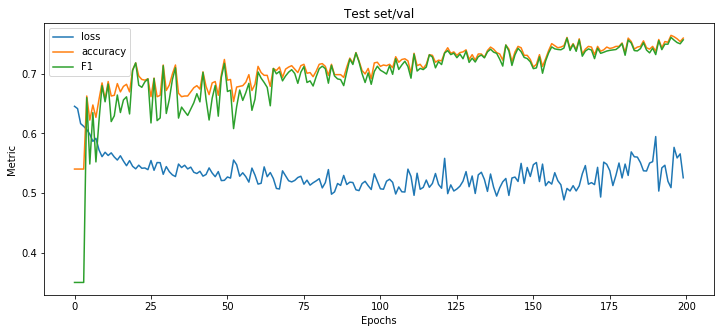

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.793103,0.737771,0.764437,0.708036,0.683828,0.70438
Confirmed,0.568602,0.642325,0.603219,0.708036,0.683828,0.70438


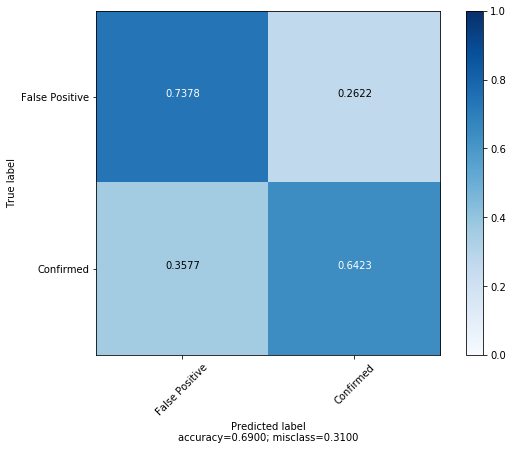

{'Precision raw': array([0.79310345, 0.56860158]),
 'Recall raw': array([0.73777065, 0.64232489]),
 'F1 raw': array([0.76443706, 0.60321903]),
 'F1 weighted': 0.708035966661413,
 'F1 macro': 0.6838280464344285,
 'F1 micro': 0.7043795620437956,
 'Confusion Matrix': array([[920, 327],
        [240, 431]])}

In [50]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod2.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7808/7810 [============================>.] - ETA: 0s - loss: 10.2902 - acc: 0.6328

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.350785 
7810/7810 [==============================] - 27s 3ms/step - loss: 10.2876 - acc: 0.6329 - val_loss: 10.4901 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 17s 2ms/step - loss: 9.8836 - acc: 0.6387 - val_loss: 10.2005 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 15s 2ms/step - loss: 9.4693 - acc: 0.6508 - val_loss: 9.6187 - val_acc: 0.6014
Epoch 4/200
7810/7810 [==============================] - 17s 2ms/step - loss: 9.1117 - acc: 0.6663 - val_loss: 9.4177 - val_acc: 0.6417
Epoch 5/200
7810/7810 [==============================] - 15s 2ms/step - loss: 9.1241 - acc: 0.6458 - val_loss: 9.2673 - val_acc: 0.6601
Epoch 6/200
7810/7810 [==============================] - 16s 2ms/step - loss: 9.0249 - acc: 0.6569 - val_loss: 9.2275 - val_acc: 0.6878
Epoch 7/200
7810/7810 [==============================] - 17s 2ms/step - loss: 8.9176 - acc: 0.6796 - val_loss: 9.1243 - val_acc: 0.6774
Epoch 8/200
7810/7810 [=============

Epoch 36/200
7810/7810 [==============================] - 16s 2ms/step - loss: 7.6494 - acc: 0.7346 - val_loss: 8.1319 - val_acc: 0.6740
Epoch 37/200
7810/7810 [==============================] - 15s 2ms/step - loss: 7.6627 - acc: 0.7321 - val_loss: 8.1062 - val_acc: 0.6820
Epoch 38/200
7810/7810 [==============================] - 16s 2ms/step - loss: 7.6029 - acc: 0.7353 - val_loss: 8.1096 - val_acc: 0.6843
Epoch 39/200
7810/7810 [==============================] - 17s 2ms/step - loss: 7.5359 - acc: 0.7380 - val_loss: 8.3627 - val_acc: 0.6659
Epoch 40/200
7810/7810 [==============================] - 16s 2ms/step - loss: 7.5429 - acc: 0.7375 - val_loss: 8.0264 - val_acc: 0.6763
Epoch 41/200
7810/7810 [==============================] - 17s 2ms/step - loss: 7.5131 - acc: 0.7428 - val_loss: 8.1965 - val_acc: 0.6682
Epoch 42/200
7810/7810 [==============================] - 16s 2ms/step - loss: 7.4738 - acc: 0.7446 - val_loss: 8.2378 - val_acc: 0.6717
Epoch 43/200
7810/7810 [=================

7810/7810 [==============================] - 16s 2ms/step - loss: 6.2790 - acc: 0.7958 - val_loss: 7.5124 - val_acc: 0.7362
Epoch 75/200
7810/7810 [==============================] - 16s 2ms/step - loss: 6.2230 - acc: 0.7954 - val_loss: 7.8419 - val_acc: 0.7154
Epoch 76/200
7810/7810 [==============================] - 15s 2ms/step - loss: 6.3451 - acc: 0.7926 - val_loss: 7.7228 - val_acc: 0.7304
Epoch 77/200
7810/7810 [==============================] - 16s 2ms/step - loss: 6.2438 - acc: 0.7985 - val_loss: 7.4637 - val_acc: 0.7200
Epoch 78/200
7810/7810 [==============================] - 15s 2ms/step - loss: 6.0968 - acc: 0.8026 - val_loss: 7.3762 - val_acc: 0.7362
Epoch 79/200
7810/7810 [==============================] - 15s 2ms/step - loss: 6.1269 - acc: 0.8014 - val_loss: 7.3534 - val_acc: 0.7385
Epoch 80/200
7810/7810 [==============================] - 15s 2ms/step - loss: 6.2922 - acc: 0.7964 - val_loss: 7.9122 - val_acc: 0.7235
Epoch 81/200
7810/7810 [==============================

7810/7810 [==============================] - 15s 2ms/step - loss: 5.1700 - acc: 0.8442 - val_loss: 6.5156 - val_acc: 0.7696
Epoch 109/200
7810/7810 [==============================] - 16s 2ms/step - loss: 5.2035 - acc: 0.8430 - val_loss: 6.9570 - val_acc: 0.7800
Epoch 110/200
7810/7810 [==============================] - 17s 2ms/step - loss: 4.9953 - acc: 0.8502 - val_loss: 6.5633 - val_acc: 0.7823
Epoch 111/200
7810/7810 [==============================] - 15s 2ms/step - loss: 5.0081 - acc: 0.8516 - val_loss: 6.5278 - val_acc: 0.7834
Epoch 112/200
7810/7810 [==============================] - 16s 2ms/step - loss: 4.9528 - acc: 0.8489 - val_loss: 6.4317 - val_acc: 0.7972
Epoch 113/200
7810/7810 [==============================] - 15s 2ms/step - loss: 4.9234 - acc: 0.8531 - val_loss: 7.1541 - val_acc: 0.7880
Epoch 114/200
7810/7810 [==============================] - 16s 2ms/step - loss: 4.8687 - acc: 0.8621 - val_loss: 6.5002 - val_acc: 0.7880
Epoch 115/200
7810/7810 [=======================

7810/7810 [==============================] - 16s 2ms/step - loss: 3.7962 - acc: 0.8990 - val_loss: 5.5025 - val_acc: 0.8329
Epoch 143/200
7810/7810 [==============================] - 15s 2ms/step - loss: 3.7915 - acc: 0.8950 - val_loss: 5.7273 - val_acc: 0.8376
Epoch 144/200
7810/7810 [==============================] - 16s 2ms/step - loss: 3.7610 - acc: 0.9023 - val_loss: 5.6119 - val_acc: 0.8157
Epoch 145/200
7810/7810 [==============================] - 16s 2ms/step - loss: 3.9691 - acc: 0.8972 - val_loss: 5.1486 - val_acc: 0.8410
Epoch 146/200
7810/7810 [==============================] - 16s 2ms/step - loss: 3.7682 - acc: 0.8995 - val_loss: 5.0412 - val_acc: 0.8525
Epoch 147/200
7810/7810 [==============================] - 17s 2ms/step - loss: 3.6428 - acc: 0.9047 - val_loss: 5.1085 - val_acc: 0.8399
Epoch 148/200
7810/7810 [==============================] - 16s 2ms/step - loss: 3.6977 - acc: 0.9022 - val_loss: 5.4366 - val_acc: 0.8479
Epoch 149/200
7810/7810 [=======================

7810/7810 [==============================] - 16s 2ms/step - loss: 2.9107 - acc: 0.9284 - val_loss: 4.1575 - val_acc: 0.8802
Epoch 177/200
7810/7810 [==============================] - 16s 2ms/step - loss: 2.7652 - acc: 0.9334 - val_loss: 4.2102 - val_acc: 0.8825
Epoch 178/200
7810/7810 [==============================] - 16s 2ms/step - loss: 3.0270 - acc: 0.9209 - val_loss: 4.1084 - val_acc: 0.8802
Epoch 179/200
7810/7810 [==============================] - 15s 2ms/step - loss: 2.9565 - acc: 0.9297 - val_loss: 4.2045 - val_acc: 0.8756
Epoch 180/200
7810/7810 [==============================] - 17s 2ms/step - loss: 2.9477 - acc: 0.9271 - val_loss: 4.1015 - val_acc: 0.8756
Epoch 181/200
7810/7810 [==============================] - 18s 2ms/step - loss: 2.9309 - acc: 0.9277 - val_loss: 3.6881 - val_acc: 0.9021
Epoch 182/200
7810/7810 [==============================] - 15s 2ms/step - loss: 2.8737 - acc: 0.9286 - val_loss: 4.1977 - val_acc: 0.8917
Epoch 183/200
7810/7810 [=======================

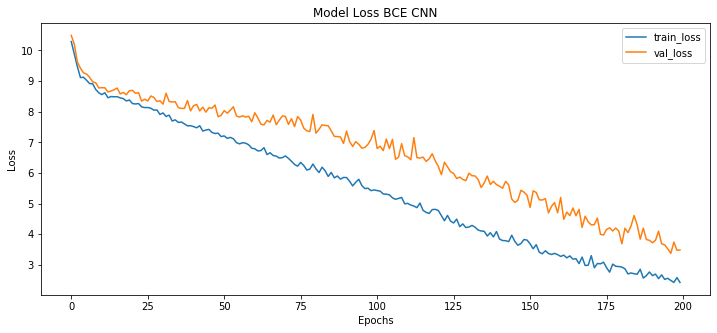

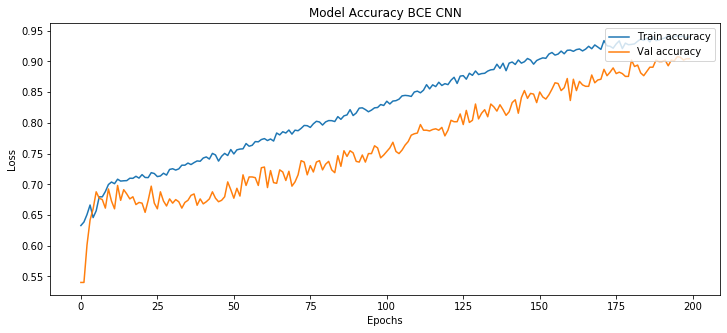

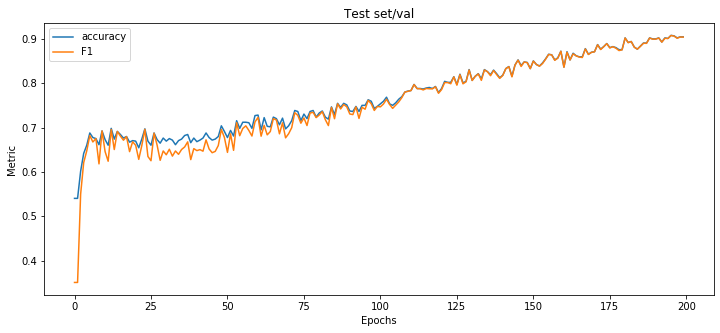

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.795882,0.712911,0.752115,0.699564,0.677009,0.694473
Confirmed,0.553059,0.660209,0.601902,0.699564,0.677009,0.694473


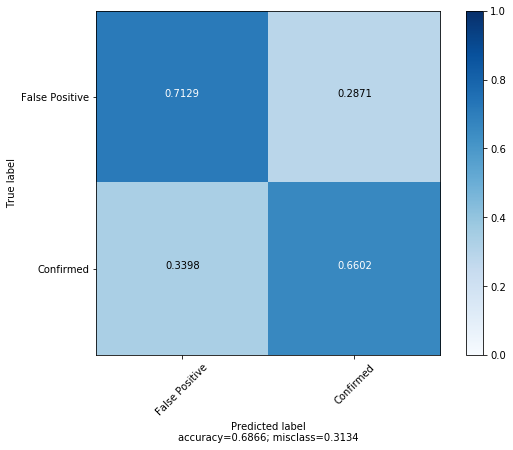

{'Precision raw': array([0.79588183, 0.55305868]),
 'Recall raw': array([0.71291099, 0.66020864]),
 'F1 raw': array([0.75211506, 0.60190217]),
 'F1 weighted': 0.6995640446011783,
 'F1 macro': 0.6770086165673508,
 'F1 micro': 0.694473409801877,
 'Confusion Matrix': array([[889, 358],
        [228, 443]])}

In [51]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod2.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256